# Figures


## Imports


In [1]:
# Standard library and other common packages
import glob
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from itertools import combinations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed,
    LSTM,
    Dense,
    Flatten,
    Conv1D,
    Reshape,
    Dropout,
    Concatenate,
)
from PIL import Image, ImageFont
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

# other packages
import dask.dataframe as dd
import neptune
import statsmodels.api as sm
from statsmodels.formula.api import ols
import h5py
from tqdm.notebook import tqdm

# local files
import constants
from solarprophet import TabularTest
import utils
import common_params

# declarations
fig_dir = os.path.join("Reports", "Images")

### Data

Load data, save as hdf5 file if it is not already for quicker access


In [2]:
data_df = utils.load_joint_data(constants.JOINT_DATA_H5_PATH)
runs_table_df = utils.load_neptune_runs()

Loading .h5 dataset


## Visuals

### Data Completeness

import ideal series data or calculate to find missing data points


In [32]:
if 1:
    if os.path.isfile(constants.IDEAL_SERIES_PATH):
        ideal_series = pd.read_csv(
            constants.IDEAL_SERIES_PATH, index_col=0, parse_dates=["dateTime"]
        )

        dates = np.unique(ideal_series.index.date)

        min_true = []
        max_true = []
        for day in dates:
            data = ideal_series[ideal_series.index.date == day]
            data = data[data["Valid Data Point"] == True]
            if len(data) > 0:
                min_true.append(data.index[0].hour + data.index[0].minute / 60)
                max_true.append(data.index[-1].hour + data.index[-1].minute / 60)
            else:
                min_true.append(min_true[-1])
                max_true.append(max_true[-1])
    else:
        ideal_series = data_df[["BRBG Total Cloud Cover [%]"]].copy().dropna()

        ideal_series["Prev dateTime"] = ideal_series.index.to_series().shift(1)
        ideal_series["Time Diff (min)"] = (
            ideal_series.index.to_series().diff().dt.total_seconds() / 60
        )
        ideal_series["First of Day"] = (
            ideal_series.index.to_series().dt.date
            > ideal_series["Prev dateTime"].dt.date
        )
        ideal_series["First of Day"][0] = True
        # ideal_series["Time Problem"] = not (ideal_series["Time Diff (min)"] != 10 or ideal_series["First of Day"])
        # ideal_series["Time Problem"] = ideal_series[(ideal_series["Time Diff (min)"] != 10)]
        ideal_series["Correct Time Interval"] = ideal_series["Time Diff (min)"] == 10
        ideal_series["Valid Data Point"] = np.logical_or(
            ideal_series["First of Day"], ideal_series["Correct Time Interval"]
        )
        ideal_series["Missing Data Point"] = False

        first_date = ideal_series.index[0].date()
        last_date = ideal_series.index[-1].date()

        iter_date = first_date
        most_recent_start_time = ideal_series.index[0]
        most_recent_end_time = ideal_series.index[-1]

        min_true = []
        max_true = []
        dates = []

        while iter_date <= last_date:
            # if date is in dataframe:
            if iter_date in ideal_series.index.date:
                start_time = sorted(
                    ideal_series[ideal_series.index.date == iter_date].index
                )[0]
                end_time = sorted(
                    ideal_series[ideal_series.index.date == iter_date].index
                )[-1]

                # account for errors in start time
                adjusted_recent_start = datetime.combine(
                    iter_date,
                    most_recent_start_time.time(),
                    tzinfo=most_recent_start_time.tzinfo,
                )
                if abs(start_time - adjusted_recent_start) > timedelta(minutes=10):
                    start_time = adjusted_recent_start
                else:
                    most_recent_start_time = start_time
                # account for errors in end time

                adjusted_recent_end = datetime.combine(
                    iter_date,
                    most_recent_end_time.time(),
                    tzinfo=most_recent_end_time.tzinfo,
                )
                if abs(end_time - adjusted_recent_end) > timedelta(minutes=40):
                    if end_time > adjusted_recent_end:
                        # end_time = adjusted_recent_end + timedelta(minutes=10)
                        end_time = adjusted_recent_end
                    elif end_time < adjusted_recent_end:
                        # end_time = adjusted_recent_end - timedelta(minutes=10)
                        end_time = adjusted_recent_end
                else:
                    most_recent_end_time = end_time

                for data_point in utils.perdelta(
                    start_time, end_time, timedelta(minutes=10)
                ):
                    if data_point not in ideal_series.index:
                        ideal_series.at[data_point, "Missing Data Point"] = True

                iter_date += timedelta(days=1)

            # if date is not in dataframe:
            else:
                start_time = datetime.combine(
                    iter_date,
                    most_recent_start_time.time(),
                    tzinfo=most_recent_start_time.tzinfo,
                )
                end_time = datetime.combine(
                    iter_date,
                    most_recent_end_time.time(),
                    tzinfo=most_recent_end_time.tzinfo,
                )
                for data_point in utils.perdelta(
                    start_time, end_time, timedelta(minutes=10)
                ):
                    if data_point not in ideal_series.index:
                        ideal_series.at[data_point, "Missing Data Point"] = True

                iter_date += timedelta(days=1)

            min_true.append(start_time.hour + start_time.minute / 60)
            max_true.append(end_time.hour + end_time.minute / 60)
            dates.append(iter_date)

        ideal_series["Error Data Point"] = np.logical_or(
            np.logical_not(ideal_series["Valid Data Point"]),
            ideal_series["Missing Data Point"],
        )
        ideal_series.sort_index(inplace=True)

        ideal_series.to_csv(constants.IDEAL_SERIES_PATH, index=True, header=True)

    complete_days = (
        ideal_series.groupby(ideal_series.index.date).sum()["Error Data Point"] == 0
    )
    complete_days[complete_days == True]

In [3]:
data_df.describe()

315nm POM-01 Photometer [nA]  400nm POM-01 Photometer [uA]  \
count                  2.630880e+06                  2.630880e+06   
mean                   3.561002e+00                  3.884156e+00   
std                    1.295912e+02                  8.955645e+00   
min                    0.000000e+00                  0.000000e+00   
25%                    0.000000e+00                  0.000000e+00   
50%                    0.000000e+00                  0.000000e+00   
75%                    1.190200e-02                  1.134000e-03   
max                    2.073400e+04                  2.897600e+02   

       500nm POM-01 Photometer [uA]  675nm POM-01 Photometer [uA]  \
count                  2.630880e+06                  2.630880e+06   
mean                   2.708889e+01                  4.595449e+01   
std                    5.884340e+01                  9.740213e+01   
min                    0.000000e+00                  0.000000e+00   
25%                    0.000000e+00                  0.000000e+00   
50%                    0.000000e+00                  0.000000e+00   
75%                    6.161000e-03                  8.557000e-03   
max                    2.854200e+02                  3.153200e+02   

       870nm POM-01 Photometer [uA]  940nm POM-01 Photometer [uA]  \
count                  2.630880e+06                  2.630880e+06   
mean                   3.654696e+01                  1.837488e+01   
std                    7.693778e+01                  4.141080e+01   
min                    0.000000e+00                  0.000000e+00   
25%                    0.000000e+00                  0.000000e+00   
50%                    0.000000e+00                  0.000000e+00   
75%                    6.867000e-03                  2.629000e-03   
max                    2.405500e+02                  2.043500e+02   

       1020nm POM-01 Photometer [uA]  Snow Depth [cm]  Precipitation [mm]  \
count                   2.630880e+06     2.630880e+06        2.630880e+06   
mean                    2.920885e+01     1.096937e+00        7.469752e-04   
std                     6.145451e+01     2.760723e+00        1.758608e-02   
min                     0.000000e+00     0.000000e+00        0.000000e+00   
25%                     0.000000e+00     0.000000e+00        0.000000e+00   
50%                     0.000000e+00     2.620000e-01        0.000000e+00   
75%                     5.241000e-03     7.840000e-01        0.000000e+00   
max                     1.887200e+02     3.040000e+01        1.118000e+01   

       Precipitation (Accumulated) [mm]  Station Pressure [mBar]  \
count                      2.630880e+06             2.630880e+06   
mean                       5.067884e-01             8.163764e+02   
std                        2.373973e+00             5.719590e+00   
min                        0.000000e+00             7.422360e+02   
25%                        0.000000e+00             8.132120e+02   
50%                        0.000000e+00             8.170620e+02   
75%                        0.000000e+00             8.203380e+02   
max                        4.267000e+01             8.479630e+02   

       Tower Dry Bulb Temp [deg C]  Tower RH [%]  Snow Depth Quality  \
count                 2.630880e+06  2.630880e+06        2.630880e+06   
mean                  1.139141e+01  4.319895e+01        1.937319e+02   
std                   1.066638e+01  2.499107e+01        1.627308e+01   
min                  -2.324000e+01  1.947000e+00        0.000000e+00   
25%                   3.353000e+00  2.356000e+01        1.938000e+02   
50%                   1.143000e+01  3.611000e+01        1.940000e+02   
75%                   1.978000e+01  5.927000e+01        1.944000e+02   
max                   3.781000e+01  1.002000e+02        5.255000e+02   

       SE Dry Bulb Temp [deg C]     SE RH [%]  Vertical Wind Shear [1/s]  \
count              2.630880e+06  2.630880e+06               2.630880e+06   
mean               1.071580e+01  

## General Data Statistics


### Distribution of Target Variables


In [5]:
if 0:
    # get actual data
    with h5py.File(os.path.join("data", "windows_cache.h5"), "r") as f:
        g = f["1"]
        cs_index_ = g["clear_sky_indexes"][:]  # (N windows, n steps in + n steps out)
        cs_irradiance_ = g["clear_sky_irradiances"][
            :
        ]  # (N windows, n steps in + n steps out)
        datetimes_ = g["datetimes"][:]  # (N windows, n steps in + n steps out)
        future_features_ = g["future_features"][
            :
        ]  # (N windows, n steps out, [constants.future_features])
        past_features_ = g["past_features"][
            :
        ]  # (N windows, n steps in, [constants.past_features])
        relative_responses_ = g["relative_responses"][
            :
        ]  # (N windows, n steps out, [Delta GHI, Delta CSI GHI])
        scalar_responses_ = g["scalar_responses"][
            :
        ]  # (N windows, n steps out , [GHI, CSI GHI, cs_dev t ghi])

    responses = {
        "GHI": scalar_responses_[:, :, 0].flatten(),
        "CSI GHI": scalar_responses_[:, :, 1].flatten(),
        "Clear Sky Deviation": scalar_responses_[:, :, 2].flatten(),
        "Delta GHI": relative_responses_[:, :, 0].flatten(),
        "Delta CSI GHI": relative_responses_[:, :, 1].flatten(),
    }
    # responses_df = pd.DataFrame(responses, index=datetimes_)
    responses_df = pd.DataFrame(responses)

    scaler = MinMaxScaler()
    scaled_responses_df = pd.DataFrame(
        scaler.fit_transform(responses_df), columns=responses_df.columns
    )

    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)

    a = sns.kdeplot(
        scaled_responses_df["GHI"],
        linestyle="-",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label="GHI",
    )
    a_mle = a.get_lines()[0].get_xdata()[np.argmax(a.get_lines()[0].get_ydata())]
    b = sns.kdeplot(
        scaled_responses_df["CSI GHI"],
        linestyle=":",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label="CSI",
    )
    b_mle = b.get_lines()[1].get_xdata()[np.argmax(b.get_lines()[1].get_ydata())]
    c = sns.kdeplot(
        scaled_responses_df["Clear Sky Deviation"],
        linestyle="--",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"CS Dev.",
    )
    c_mle = c.get_lines()[2].get_xdata()[np.argmax(c.get_lines()[2].get_ydata())]
    d = sns.kdeplot(
        scaled_responses_df["Delta GHI"],
        linestyle="-.",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"$\Delta$ GHI",
    )
    d_mle = d.get_lines()[3].get_xdata()[np.argmax(d.get_lines()[3].get_ydata())]
    e = sns.kdeplot(
        scaled_responses_df["Delta CSI GHI"],
        linestyle="-",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"$\Delta$ CSI",
    )
    e_mle = e.get_lines()[4].get_xdata()[np.argmax(e.get_lines()[4].get_ydata())]

    ax.set_xlabel("Scaled Response Value")
    ax.set_ylabel("Density")
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_xticks(np.arange(0.1, 1.1, 0.2), minor=True)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # ax.grid(True)

    # set legend at bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.17),
        # fancybox=True, shadow=True,
        ncol=3,
    )

    ax.add_artist(common_params.TickRedrawer())

    # eps_path = os.path.join(fig_dir, "target_distribution_kde.eps")
    pdf_path = os.path.join(fig_dir, "target_distribution_kde.pdf")

    # fig.savefig(eps_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")

    plt.show()

    # stats
    print("Maximum likelyhood estimation:")
    print(f"GHI MLE: {a_mle}")
    print(f"CSI MLE: {b_mle}")
    print(f"CS Dev MLE: {c_mle}")
    print(f"Delta GHI MLE: {d_mle}")
    print(f"Delta CSI MLE: {e_mle}")

    print("\nMean:")
    for column_name in scaled_responses_df.columns:
        mean = np.mean(scaled_responses_df[column_name])
        print(f"{column_name}: Mean: {mean} ")

    print("\nVariance:")
    for column_name in scaled_responses_df.columns:
        var = np.var(scaled_responses_df[column_name])
        print(f"{column_name}: Mean: {var} ")

    print("\nStandard Deviation:")
    for column_name in scaled_responses_df.columns:
        var = np.std(scaled_responses_df[column_name])
        print(f"{column_name}: Mean: {var} ")

    print("\nSkewness:")
    for column_name in scaled_responses_df.columns:
        statistic_val, p_val = stats.skewtest(scaled_responses_df[column_name])
        print(f"{column_name}: Test Statistic: {statistic_val} P-value: {p_val}")

    print("\nKurtosis:")
    for column_name in scaled_responses_df.columns:
        statistic_val, p_val = stats.kurtosistest(scaled_responses_df[column_name])
        print(f"{column_name}: Test Statistic: {statistic_val} P-value: {p_val}")

    print("\nShapiro-Wilk Normal Test:")
    for column_name in scaled_responses_df.columns:
        statistic_val, p_val = stats.normaltest(scaled_responses_df[column_name])
        print(f"{column_name}: Test Statistic: {statistic_val} P-value: {p_val}")

cumulative distribution


In [6]:
if 0:
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)

    a = sns.kdeplot(
        scaled_responses_df["GHI"],
        linestyle="-",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label="GHI",
        cumulative=True,
    )
    b = sns.kdeplot(
        scaled_responses_df["CSI GHI"],
        linestyle=":",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label="CSI",
        cumulative=True,
    )
    c = sns.kdeplot(
        scaled_responses_df["Clear Sky Deviation"],
        linestyle="--",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"CS Dev.",
        cumulative=True,
    )
    d = sns.kdeplot(
        scaled_responses_df["Delta GHI"],
        linestyle="-.",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"$\Delta$ GHI",
        cumulative=True,
    )
    e = sns.kdeplot(
        scaled_responses_df["Delta CSI GHI"],
        linestyle="-",
        clip=(0, 1),
        fill=False,
        ax=ax,
        label=r"$\Delta$ CSI",
        cumulative=True,
    )
    ax.set_xlabel("Scaled Response Value")
    ax.set_ylabel("Density")
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_xticks(np.arange(0.1, 1.1, 0.2), minor=True)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # ax.grid(True)

    # set legend at bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.17),
        # fancybox=True, shadow=True,
        ncol=3,
    )

    ax.add_artist(common_params.TickRedrawer())

    # eps_path = os.path.join(fig_dir, "target_distribution_kde.eps")
    pdf_path = os.path.join(fig_dir, "cumulative_target_distribution_kde.pdf")

    # fig.savefig(eps_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")

### Autocorrelation


In [7]:
if 0:
    # get actual data
    with h5py.File(os.path.join("data", "windows_cache.h5"), "r") as f:
        g = f["13"]
        cs_index_ = g["clear_sky_indexes"][:]  # (N windows, n steps in + n steps out)
        cs_irradiance_ = g["clear_sky_irradiances"][
            :
        ]  # (N windows, n steps in + n steps out)
        datetimes_ = g["datetimes"][:]  # (N windows, n steps in + n steps out)
        future_features_ = g["future_features"][
            :
        ]  # (N windows, n steps out, [constants.future_features])
        past_features_ = g["past_features"][
            :
        ]  # (N windows, n steps in, [constants.past_features])
        relative_responses_ = g["relative_responses"][
            :
        ]  # (N windows, n steps out, [Delta GHI, Delta CSI GHI])
        scalar_responses_ = g["scalar_responses"][
            :
        ]  # (N windows, n steps out , [GHI, CSI GHI, cs_dev t ghi])
    irradiance_ = cs_index_ * cs_irradiance_
    cs_dev_ = cs_irradiance_ - irradiance_

    responses = {
        "GHI": scalar_responses_[:, :, 0],
        "CSI GHI": scalar_responses_[:, :, 1],
        "Clear Sky Deviation": scalar_responses_[:, :, 2],
        "Delta GHI": relative_responses_[:, :, 0],
        "Delta CSI GHI": relative_responses_[:, :, 1],
    }
    # Need to find prev correlation, relative responses? hw to get prev val correlation?

    columns = [f"t+{i}" for i in range(0, 26)]
    irradiance_scaler = MinMaxScaler()
    scaled_irradiance = irradiance_scaler.fit_transform(irradiance_)

    i_res = stats.spearmanr(scaled_irradiance, axis=0)
    csi_res = stats.spearmanr(cs_index_, axis=0)

    cs_dev_scaler = MinMaxScaler()
    scaled_cs_dev = irradiance_scaler.fit_transform(cs_dev_)
    cs_dev_res = stats.spearmanr(scaled_cs_dev, axis=0)

Autocorrelation bar graph


In [8]:
if 0:
    plt.rcParams["axes.axisbelow"] = False
    fig, ax = plt.subplots(figsize=(3.5, 2.7), dpi=1000)

    ax.vlines(
        x=np.arange(25) - 0.195,
        ymin=0,
        ymax=csi_res.statistic[0],
        color="tab:blue",
        label="CSI",
        zorder=1,
        linewidth=1.5,
    )
    ax.vlines(
        x=np.arange(25),
        ymin=0,
        ymax=i_res.statistic[0],
        color="tab:orange",
        label="GHI",
        zorder=2,
        linewidth=1.5,
    )
    ax.vlines(
        x=np.arange(25) + 0.195,
        ymin=0,
        ymax=cs_dev_res.statistic[0],
        color="tab:red",
        label="CS Dev",
        zorder=2,
        linewidth=1.5,
    )

    ax.hlines(y=1, xmin=-0.05, xmax=24.5, linestyles="--", linewidth=1, color="black")

    ax.set_xlim(-0.5, 24.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Spearman Rank Correlation Coefficient")

    ax.legend()
    # ax.grid(True)
    ax.set_axisbelow(True)
    ax.add_artist(common_params.TickRedrawer())  # This line added.
    ax.hlines(y=0, xmin=0, xmax=25, linestyles="-", linewidth=0.5, color="black")

    # fig.savefig("Reports/Images/autocorrelation_bar.png", bbox_inches="tight", dpi=1000)
    # fig.savefig("Reports/Images/autocorrelation_bar.pdf", bbox_inches="tight", dpi=1000)
    # fig.savefig("Reports/Images/autocorrelation_bar.svg", bbox_inches="tight", dpi=1000)

    plt.show()

Scatterplot Correlation


In [9]:
if 0:
    # plt.rcParams["axes.axisbelow"] = False
    fig, ax = plt.subplots(figsize=(3.5, 2.7), dpi=1000)

    ax.scatter(
        x=np.arange(25),
        y=csi_res.statistic[0],
        edgecolors="tab:blue",
        facecolors="none",
        label="CSI",
        zorder=2,
        marker="o",
        s=15,
        alpha=0.9,
    )
    ax.scatter(
        x=np.arange(25),
        y=i_res.statistic[0],
        edgecolors="tab:orange",
        facecolors="none",
        label="GHI",
        zorder=2,
        marker="s",
        s=15,
        alpha=0.9,
    )
    ax.scatter(
        x=np.arange(25),
        y=cs_dev_res.statistic[0],
        c="tab:red",
        label="CS Dev",
        zorder=2,
        marker="x",
        s=15,
        alpha=0.9,
    )

    ax.hlines(
        y=1,
        xmin=-0.05,
        xmax=24.5,
        linestyles="--",
        linewidth=1,
        zorder=1,
        color="black",
    )
    ax.hlines(
        y=0, xmin=0, xmax=25, linestyles="-", linewidth=0.5, zorder=1, color="black"
    )

    ax.set_xlim(-0.5, 24.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Spearman Rank Correlation Coefficient")
    ax.yaxis.set_label_coords(-0.1, 0.4)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.17),
        # fancybox=True, shadow=True,
        ncol=3,
    )

    ax.add_artist(common_params.TickRedrawer())  # This line added.

    # fig.savefig(os.path.join(fig_dir, "autocorrelation_plot.png"), bbox_inches="tight", dpi=1000)
    fig.savefig(
        os.path.join(fig_dir, "autocorrelation_plot.pdf"), bbox_inches="tight", dpi=1000
    )
    # fig.savefig(os.path.join(fig_dir, "autocorrelation_plot.svg"), bbox_inches="tight", dpi=1000)

    plt.show()

### Time Series Stats

Show stationarity, seasonality, residual using cs deviation


In [ ]:
trend = data_df["cs_dev t ghi"].rolling(20_160).mean()  # 20,160 = 2 weeks in minutes
st_dev_trend = data_df["cs_dev t ghi"].rolling(20_160).std()

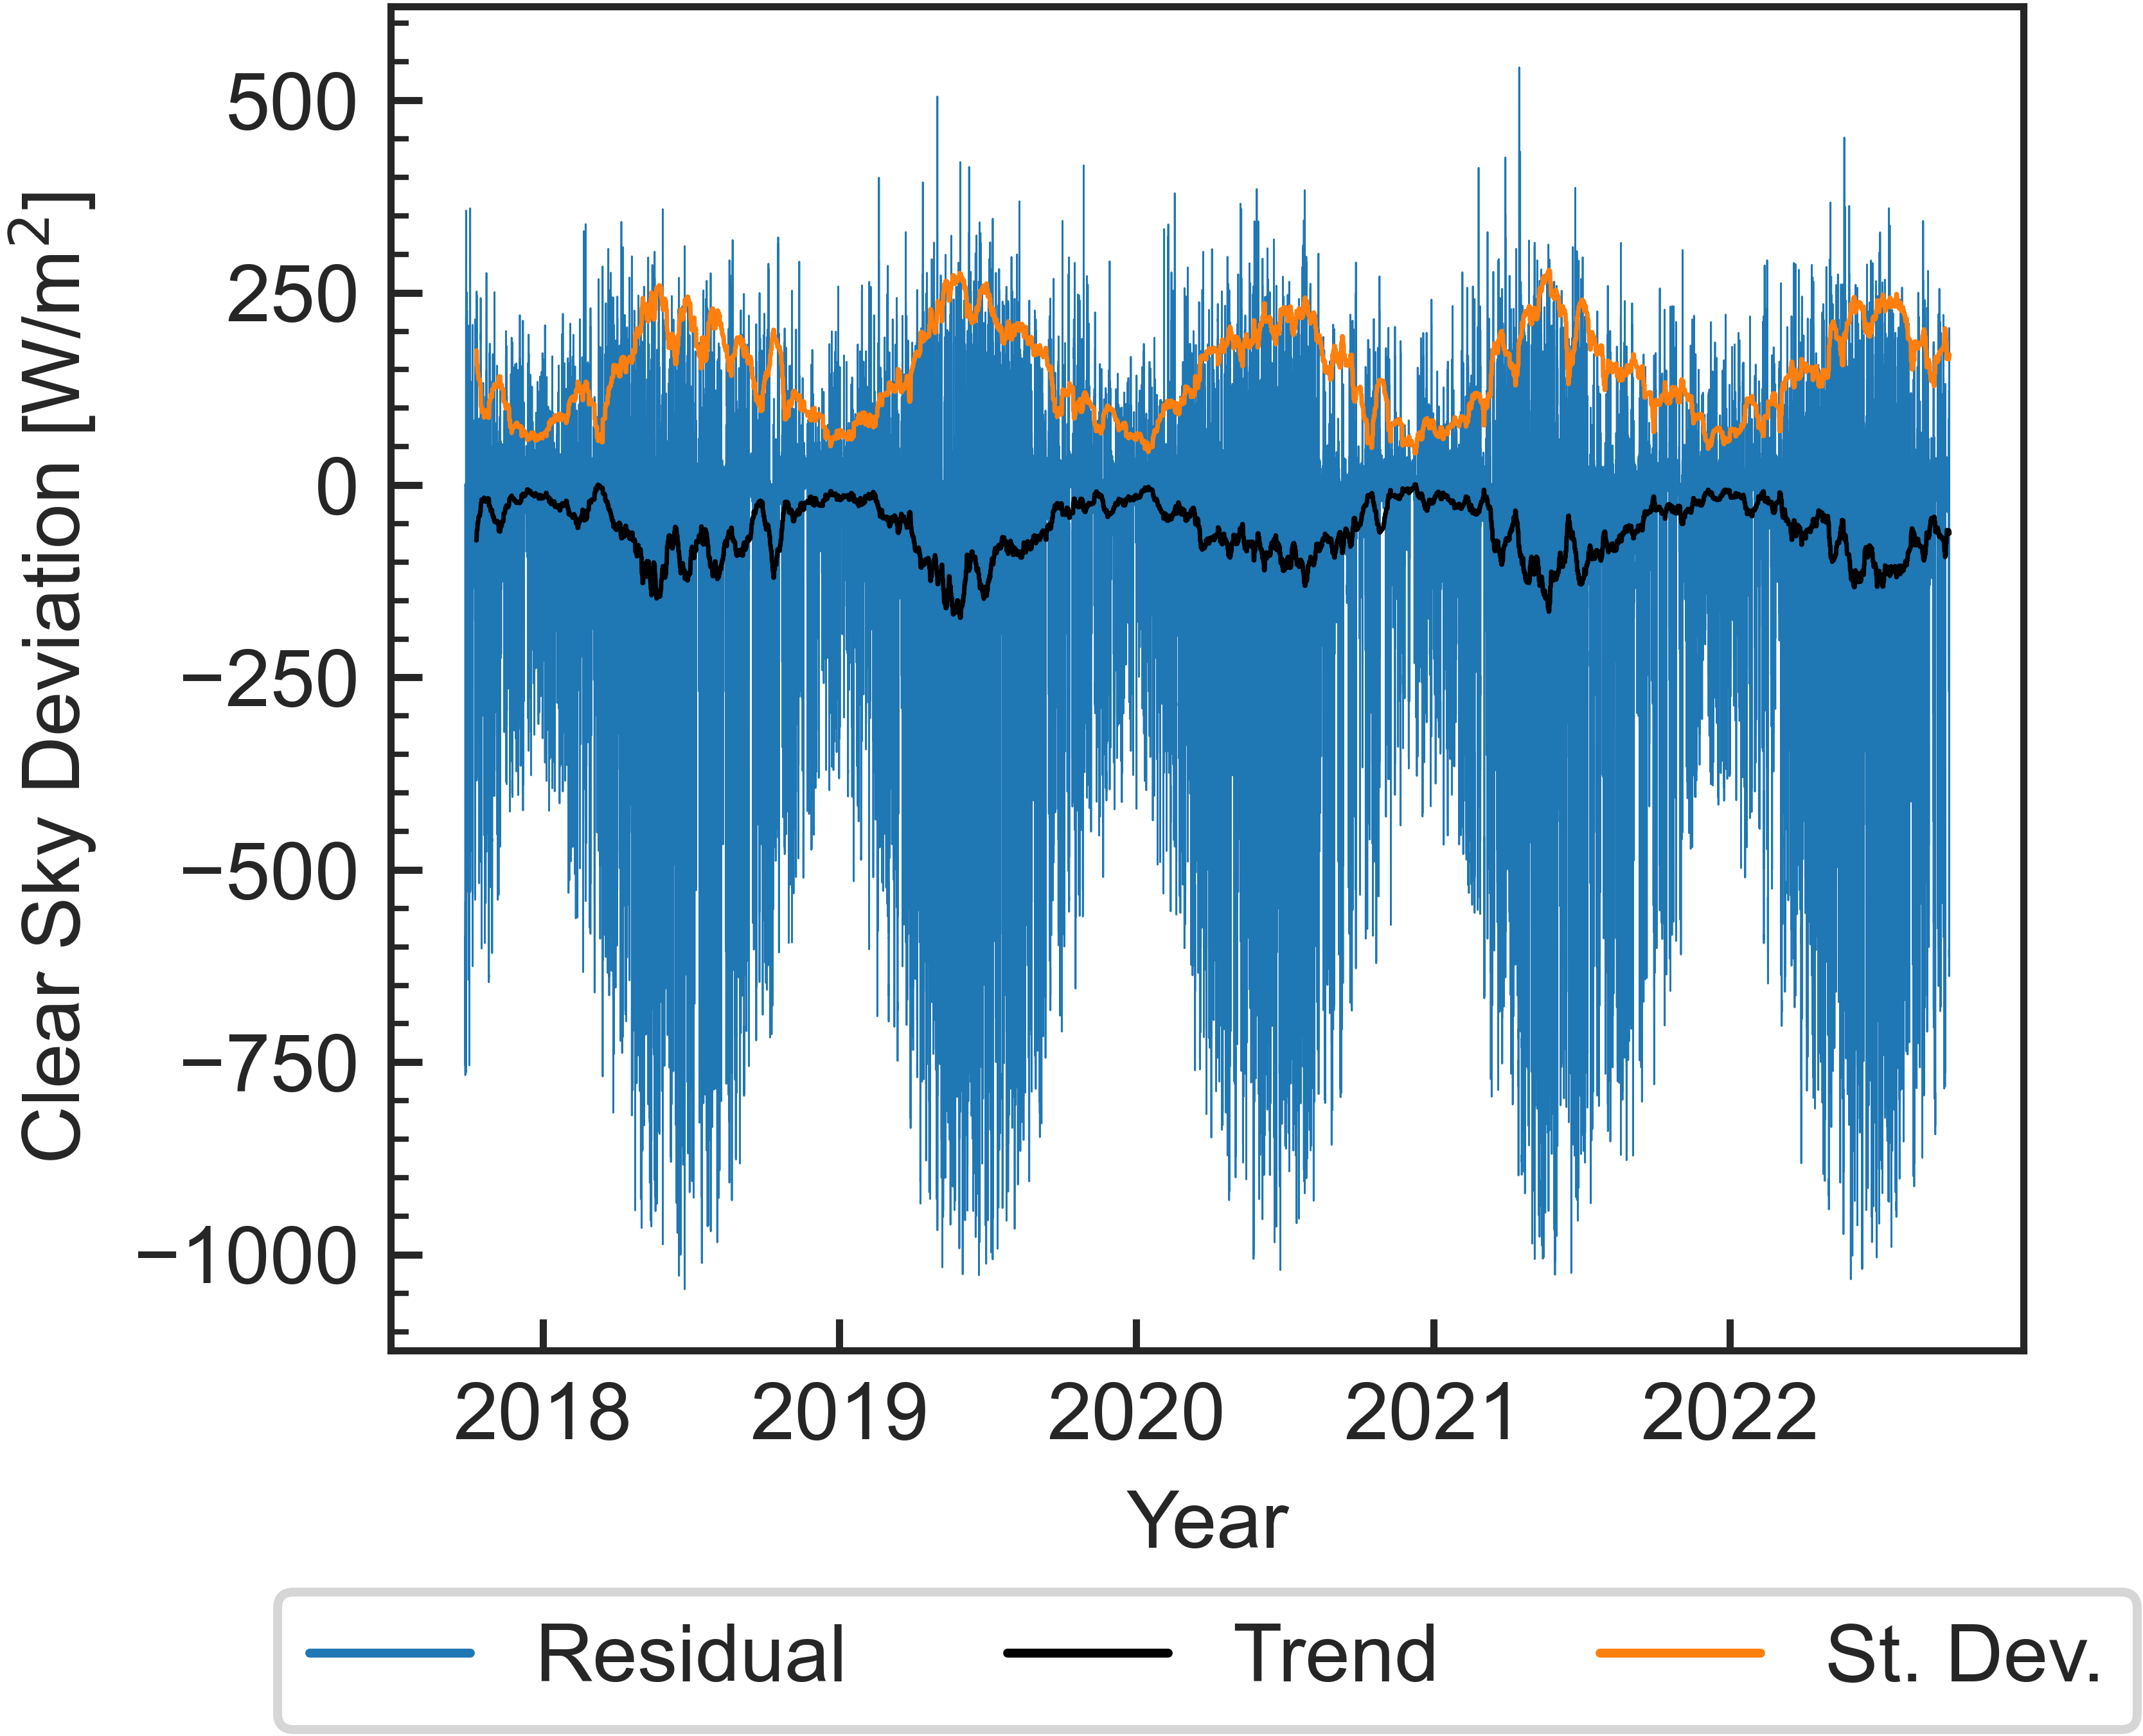

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), sharex=True, dpi=1000)

ax.plot(
    data_df.index,
    data_df["cs_dev t ghi"],
    color="tab:blue",
    linewidth=0.2,
    label="Residual",
)
ax.plot(trend.index, trend, color="black", linewidth=0.5, label="Trend")
ax.plot(
    st_dev_trend.index,
    st_dev_trend,
    color="tab:orange",
    linewidth=0.5,
    label="Std. Dev.",
)

ax.set_ylabel(r"Clear Sky Deviation [W/m$^2$]")
ax.set_xlabel("Year")
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

new_leg = [
    mlines.Line2D([], [], color="tab:blue", linewidth=1.0, label="Residual"),
    mlines.Line2D([], [], color="black", linewidth=1.0, label="Trend"),
    mlines.Line2D([], [], color="tab:orange", linewidth=1.0, label="St. Dev."),
]

# Put a legend below current axis
ax.legend(handles=new_leg, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

fig.tight_layout()

fig.savefig("Reports/Images/seasonality.pdf", bbox_inches="tight", dpi=1000)

plt.show()

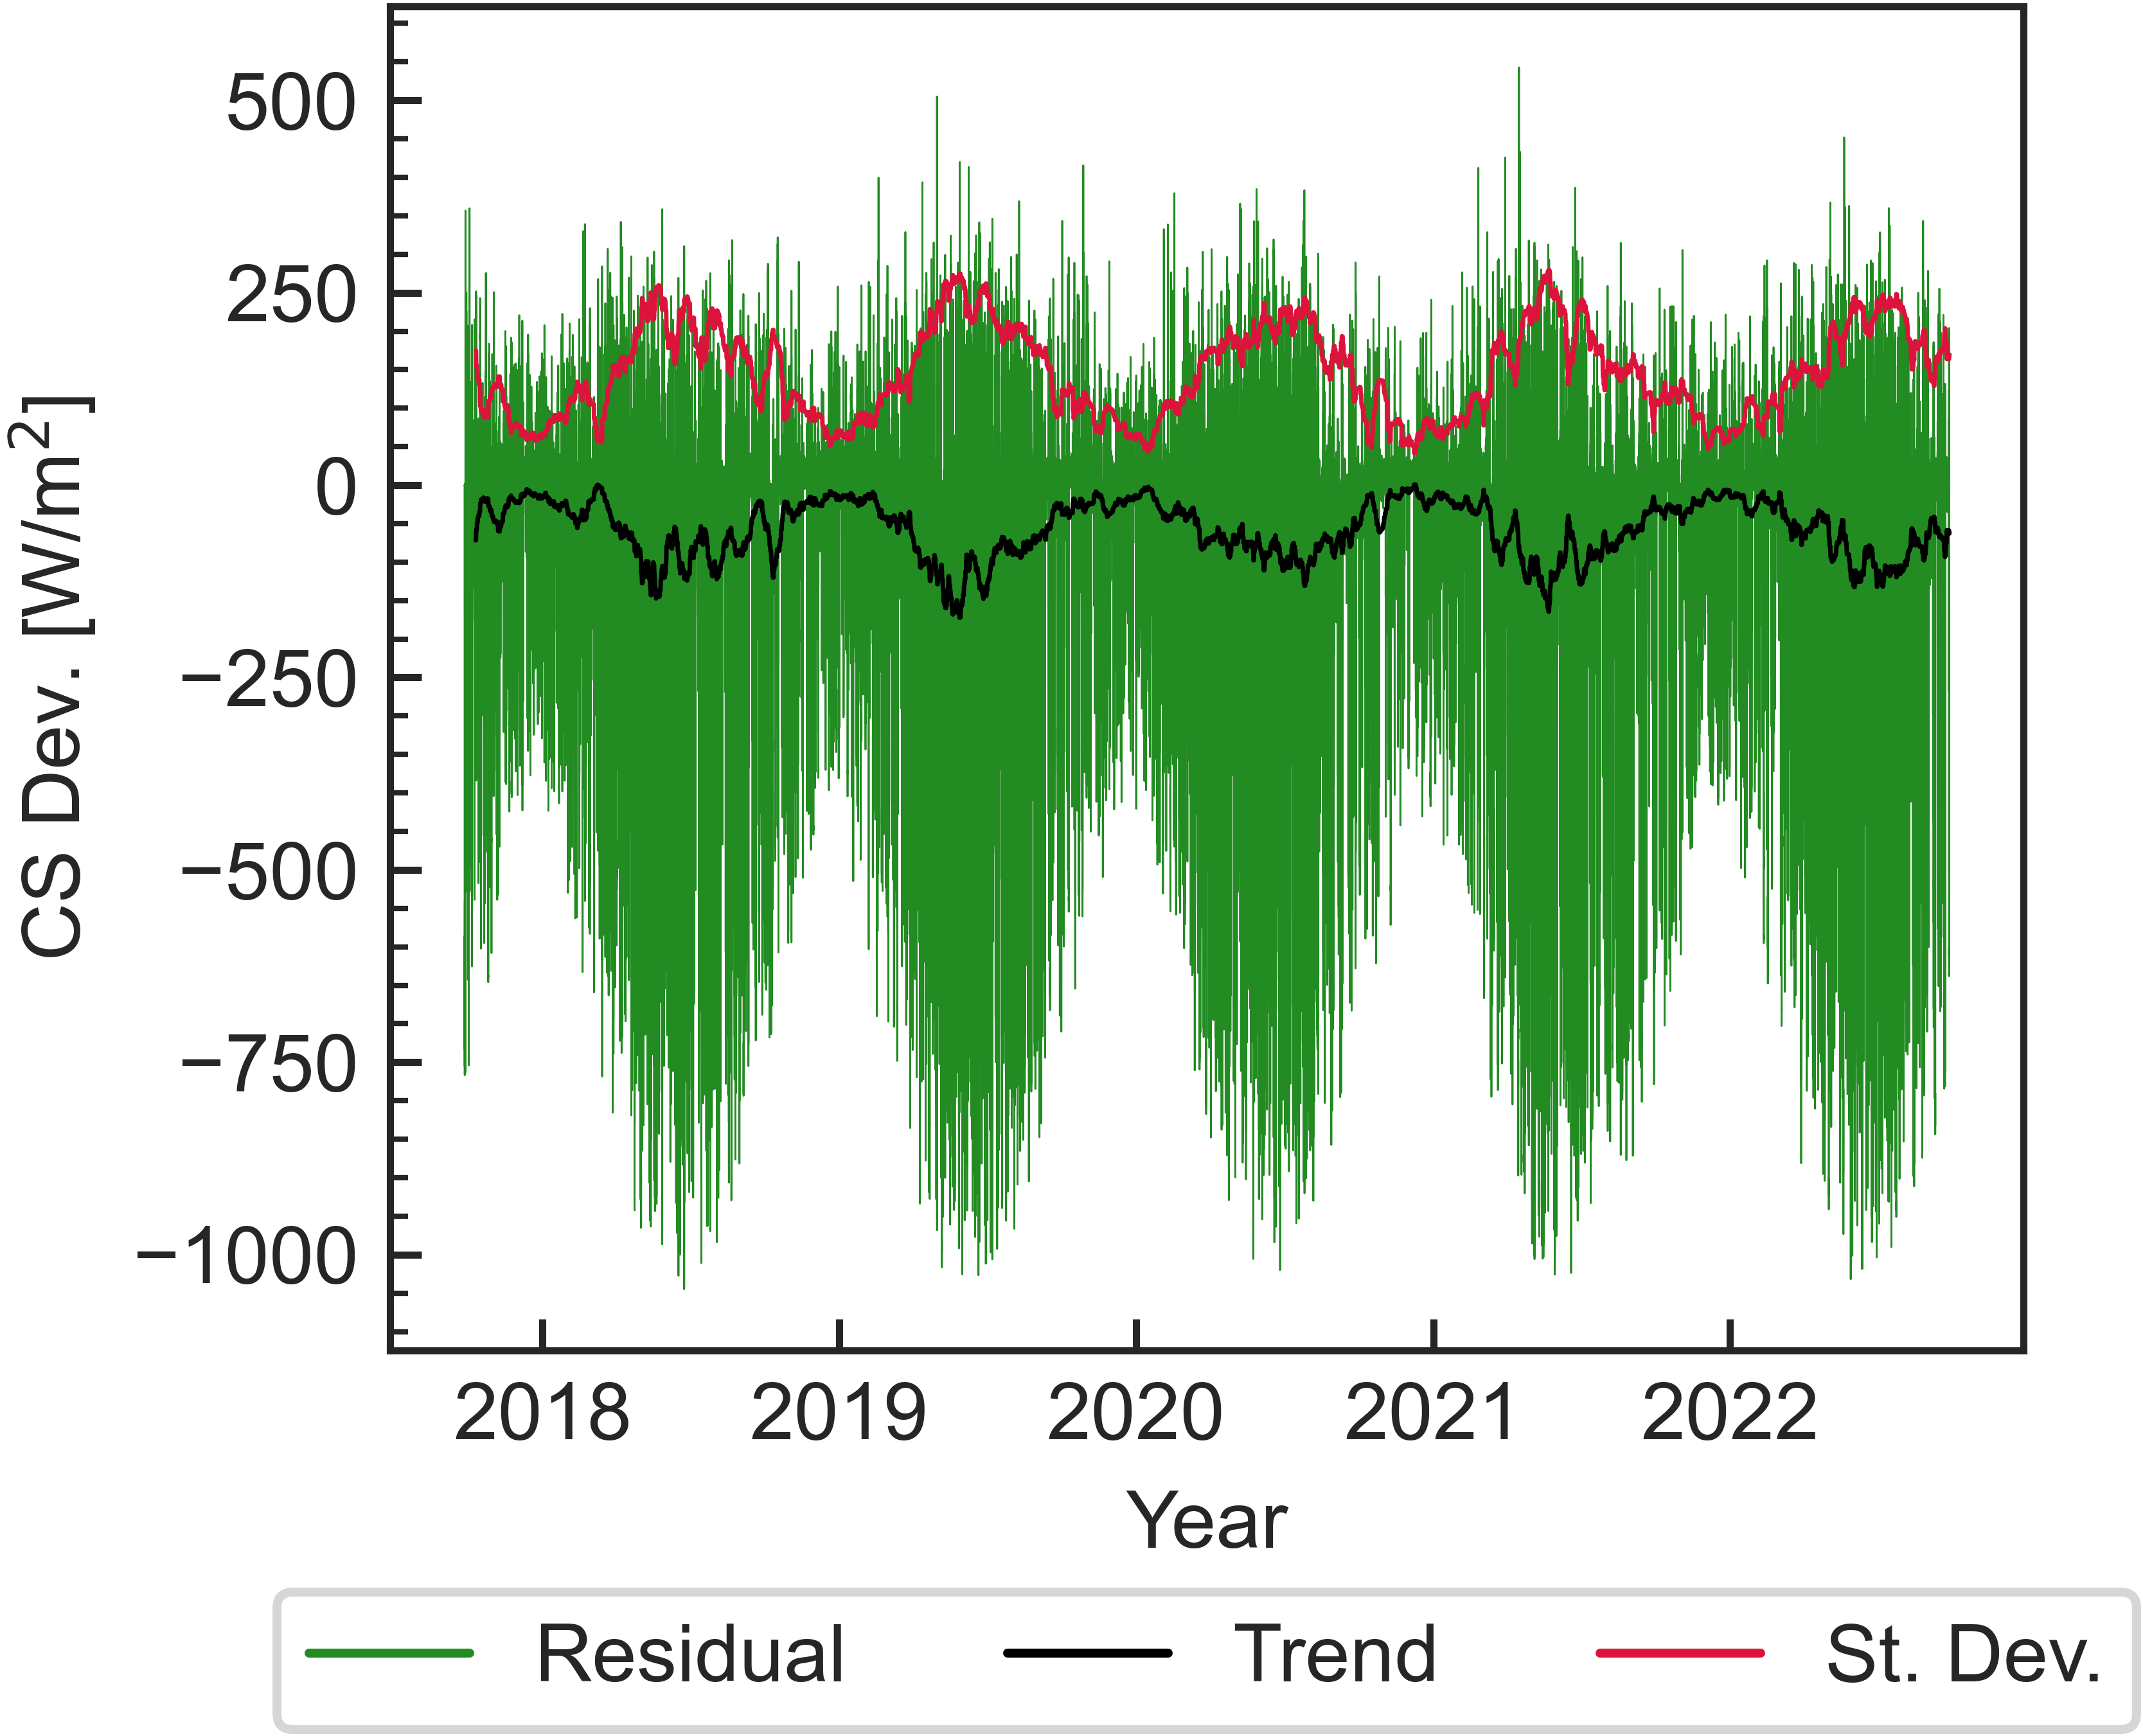

In [3]:
if 1:
    trend = (
        data_df["cs_dev t ghi"].rolling(20_160).mean()
    )  # 20,160 = 2 weeks in minutes
    st_dev_trend = data_df["cs_dev t ghi"].rolling(20_160).std()

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), sharex=True, dpi=1000)
    # df.plot(subplots=True,layout=(3,1), ax=axs, legend=False, sharex=True, linewidth=0.2)
    # axs[0].plot(data_df.index, data_df["GHI"], color="royalblue", linewidth=0.2, label="Measured GHI")
    # axs[1].plot(data_df.index, data_df["clearsky ghi"], color="orangered", linewidth=0.2, label="Seasonality")
    ax.plot(
        data_df.index,
        data_df["cs_dev t ghi"],
        color="forestgreen",
        linewidth=0.2,
        label="Residual",
    )
    ax.plot(trend.index, trend, color="black", linewidth=0.5, label="Trend")
    ax.plot(
        st_dev_trend.index,
        st_dev_trend,
        color="crimson",
        linewidth=0.5,
        label="Std. Dev.",
    )
    # ax2 = ax.twinx()
    # rolling_avg_days = 30
    # # ax2.plot(data_df.index, data_df['GHI'].rolling(rolling_avg_days*144).mean(), color="orange", linewidth=0.5, label=f"{rolling_avg_days}-day mean")
    # ax2.plot(data_df.index, data_df['GHI'].rolling(rolling_avg_days*144).median(), color="orange", linewidth=0.5, label=f"{rolling_avg_days}-day median")

    # axs[0].set_xlim(data_df.index[0], data_df.index[-1])
    # axs[0].set_ylabel(r"GHI [W/m$^2$]"+"\n", labelpad=0.5)
    # axs[0].set_ylim(0, 1500)
    # axs[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # axs[1].set_ylabel(r"CS [W/m$^2$]"+"\n", labelpad=0.5)
    # axs[1].set_ylim(0, 1200)
    # axs[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_ylabel(r"CS Dev. [W/m$^2$]")
    ax.set_xlabel("Year")
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    new_leg = [
        mlines.Line2D([], [], color="forestgreen", linewidth=1.0, label="Residual"),
        mlines.Line2D([], [], color="black", linewidth=1.0, label="Trend"),
        mlines.Line2D([], [], color="crimson", linewidth=1.0, label="St. Dev."),
        # mlines.Line2D([], [], color="crimson", linewidth=1.0, label="St. Dev.")
    ]

    # Put a legend below current axis
    ax.legend(
        handles=new_leg,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        # fancybox=True, shadow=True,
        ncol=3,
    )

    fig.tight_layout()

    fig.savefig("Reports/Images/seasonality.pdf", bbox_inches="tight", dpi=1000)

    plt.show()

Old Graph


In [10]:
if 0:
    trend = (
        data_df["cs_dev t ghi"].rolling(20_160).mean()
    )  # 20,160 = 2 weeks in minutes
    st_dev_trend = data_df["cs_dev t ghi"].rolling(20_160).std()

    fig, axs = plt.subplots(3, 1, figsize=(3.5, 3), sharex=True, dpi=1000)
    # df.plot(subplots=True,layout=(3,1), ax=axs, legend=False, sharex=True, linewidth=0.2)
    axs[0].plot(
        data_df.index,
        data_df["GHI"],
        color="royalblue",
        linewidth=0.2,
        label="Measured GHI",
    )
    axs[1].plot(
        data_df.index,
        data_df["clearsky ghi"],
        color="orangered",
        linewidth=0.2,
        label="Seasonality",
    )
    axs[2].plot(
        data_df.index,
        data_df["cs_dev t ghi"],
        color="forestgreen",
        linewidth=0.2,
        label="Residual",
    )
    axs[2].plot(trend.index, trend, color="black", linewidth=0.5, label="Trend")
    axs[2].plot(
        st_dev_trend.index,
        st_dev_trend,
        color="crimson",
        linewidth=0.5,
        label="Std. Dev.",
    )

    axs[0].set_xlim(data_df.index[0], data_df.index[-1])
    axs[0].set_ylabel(r"GHI [W/m$^2$]" + "\n", labelpad=0.5)
    axs[0].set_ylim(0, 1500)
    axs[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[1].set_ylabel(r"CS [W/m$^2$]" + "\n", labelpad=0.5)
    axs[1].set_ylim(0, 1200)
    axs[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[2].set_ylabel(r"CS Dev. [W/m$^2$]")
    axs[2].set_xlabel("Year")
    axs[2].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    new_leg = [
        mlines.Line2D([], [], color="forestgreen", linewidth=1.0, label="Residual"),
        mlines.Line2D([], [], color="black", linewidth=1.0, label="Trend"),
        mlines.Line2D([], [], color="crimson", linewidth=1.0, label="St. Dev."),
    ]

    fig.subplots_adjust(hspace=0.05)

    ax = axs[-1]

    # Put a legend below current axis
    ax.legend(
        handles=new_leg,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.5),
        # fancybox=True, shadow=True,
        ncol=3,
    )

    fig.tight_layout()

    # # fig.savefig("Reports/Images/seasonality.png", bbox_inches="tight", dpi=1000)
    fig.savefig("Reports/Images/seasonality.pdf", bbox_inches="tight", dpi=1000)
    # # fig.savefig("Reports/Images/seasonality.svg", bbox_inches="tight", dpi=1000)

    # plt.show()

## Missing Data


Visualize missing data points

Data quality and maintenance records available at https://midcdmz.nrel.gov/apps/html.pl?site=SRRLASI;page=instruments#ASI  
**A** Corresponds to R#3 on the Data quality statement and a firmware issue on 10-20% of the images  
**B** Corresponds to a firmware issue noted by researcher Afshin Andreas (personal correspondence)  
**C** Corresponds to R#7 on the DQS: "software tends to ignore all images at 0:00 GMT (17:00 MST) and occasional a few other chucks of random time stamps. These images will be missing from MIDC due to this bug."


In [11]:
if 0:
    # fig, ax = plt.subplots(figsize=(12, 5))
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)

    x_true = ideal_series.index.date[ideal_series["Error Data Point"] == True]
    y_true = (
        ideal_series.index.hour[ideal_series["Error Data Point"] == True]
        + ideal_series.index.minute[ideal_series["Error Data Point"] == True] / 60
    )

    synthetic_year_d = {}
    for i, d in enumerate(dates):
        if d.year == 2019:
            synthetic_year_d[d.strftime("%j")] = [min_true[i], max_true[i]]

    synthetic_min_true = [
        synthetic_year_d.get(d.strftime("%j"), [7.5, 16.1])[0] for d in dates
    ]
    synthetic_max_true = [
        synthetic_year_d.get(d.strftime("%j"), [7.5, 16.1])[1] for d in dates
    ]

    plt.fill_between(
        dates,
        synthetic_min_true,
        synthetic_max_true,
        color="lightgray",
        label="Valid Data Range",
    )
    plt.scatter(
        x_true,
        y_true,
        marker="o",
        color="black",
        edgecolors="none",
        s=1,
        label="Missing Data",
    )

    plt.xlabel("Date", size="large")
    plt.ylabel("Time of Day (Hour)", size="large")

    ax.set_yticks(np.arange(4, 22, 2))

    plt.text(date(2019, 3, 15), 19.5, "A")
    plt.text(date(2022, 8, 15), 19, "B")

    firmware_1500_year = 2017
    firmware_1500_month = 12

    plt.text(date(firmware_1500_year, firmware_1500_month, 10), 17.5, "C")
    plt.text(date(firmware_1500_year + 1, firmware_1500_month, 10), 17.5, "C")
    plt.text(date(firmware_1500_year + 2, firmware_1500_month, 10), 17.5, "C")
    plt.text(date(firmware_1500_year + 3, firmware_1500_month, 10), 17.5, "C")
    plt.text(date(firmware_1500_year + 4, firmware_1500_month, 10), 17.5, "C")

    plt.ylim(4, 20.5)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        # fancybox=True, shadow=True,
        ncol=2,
    )
    # fig.savefig("Reports/Images/missing_data.eps", bbox_inches="tight")
    fig.savefig("Reports/Images/missing_data.pdf", bbox_inches="tight")
    # plt.grid(alpha=0.3)
    plt.show()

### Graph a Typical Day

Requires relative paths on HAMRAM to get NREL iamges


In [12]:
if 0:
    selected_date = datetime.date(2022, 5, 18)
    selected_time = datetime.time(10, 0)
    my_datetime = pd.to_datetime(
        datetime.datetime.combine(selected_date, selected_time)
    ).tz_localize("MST")

    df_selection = data_df[data_df.index.date == selected_date].dropna()

    df = df_selection.copy()
    current_time_df = df[df.index == my_datetime]
    before_df = df[df.index < my_datetime]
    input_cutoff = my_datetime - datetime.timedelta(hours=5)
    input_df = before_df[before_df.index >= input_cutoff]
    after_current_time = df[df.index > my_datetime]
    prediction_cutoff = my_datetime + datetime.timedelta(hours=2)
    prediction_df = after_current_time[after_current_time.index <= prediction_cutoff]

    images_dir = os.path.join(
        "B:", "projects", "stellar", "data", "NREL", my_datetime.strftime("%Y%m%d")
    )
    image_times = [
        datetime.time(5, 0),
        datetime.time(7, 0),
        datetime.time(9, 0),
        datetime.time(11, 0),
        datetime.time(13, 0),
        datetime.time(15, 0),
        datetime.time(17, 10),
        datetime.time(19, 0),
    ]
    image_paths = [
        os.path.join(
            images_dir,
            datetime.datetime.combine(selected_date, t).strftime("%Y%m%d%H%M%S")
            + "_Raw_NE.jpg",
        )
        for t in image_times
    ]

    fig = plt.figure(figsize=(7, 4), dpi=1000)
    grid_rows = 8
    grid_cols = 8
    image_rows = 2
    gridspec = fig.add_gridspec(grid_rows, grid_cols)
    image_row_start = grid_rows - image_rows
    ax = fig.add_subplot(gridspec[0:-image_rows, :])
    ax_img0 = fig.add_subplot(gridspec[image_row_start:, 0])
    ax_img1 = fig.add_subplot(gridspec[image_row_start:, 1])
    ax_img2 = fig.add_subplot(gridspec[image_row_start:, 2])
    ax_img3 = fig.add_subplot(gridspec[image_row_start:, 3])
    ax_img4 = fig.add_subplot(gridspec[image_row_start:, 4])
    ax_img5 = fig.add_subplot(gridspec[image_row_start:, 5])
    ax_img6 = fig.add_subplot(gridspec[image_row_start:, 6])
    ax_img7 = fig.add_subplot(gridspec[image_row_start:, 7])

    image_axes = [
        ax_img0,
        ax_img1,
        ax_img2,
        ax_img3,
        ax_img4,
        ax_img5,
        ax_img6,
        ax_img7,
    ]

    # ax.set_title(f"Irradiance Measured at NREL on {my_datetime.strftime('%B %d, %Y')}", loc="center")

    # a = sns.scatterplot(data=df, x=df.index, y="GHI", color="orange", marker='X', label="Measured Irradiance", ax=ax)
    # b = sns.lineplot(data=df, x=df.index, y="clearsky ghi", color="red",marker='o', label="Clear Sky Irradiance".title(), ax=ax)
    a = ax.scatter(
        df.index, df["GHI"], color="black", marker="o", s=1, label="Measured Irradiance"
    )
    b = ax.plot(
        df.index, df["clearsky ghi"], color="red", label="Clear Sky Irradiance".title()
    )
    # ax2 = ax.twinx()
    # # sns.lineplot(data=df, x=df.index.time, y="CDOC Total Cloud Cover [%]",marker='o', color="gray", alpha=0.5, label="Cloud Cover", ax=ax2)
    # c = sns.lineplot(data=df, x=df.index, y=df["CSI GHI"]*100, color="blue",marker='o', alpha=0.7, label="clear sky index".title(), ax=ax2)

    ax.set_ylabel(r"GHI (W/m$^2$)")
    # ax2.set_ylabel(r"Clear Sky Index (%)")
    # ax2.set_ylim(0, 155)

    ax.xaxis.set_major_formatter(DateFormatter("%H:%M", tz=df.index.tz))
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(5, 21, 2), tz=df.index.tz))

    # ax.grid()
    # h1,l1 = ax.get_legend_handles_labels()
    # h2,l2 = ax2.get_legend_handles_labels()
    # ax2.legend(h1+h2,l1+l2, framealpha=1, loc="upper right")
    # ax.get_legend().remove()
    ax.legend()
    ax.set_xlabel(None)
    ax.set_xlim(
        df.index.min() - datetime.timedelta(minutes=40),
        df.index.max() + datetime.timedelta(minutes=30),
    )
    # x_ticks = ax.get_xticks()
    # ax.set_xticklabels(["" for i in x_ticks])

    # images
    image_titles = "ABCDEFGHIJ"
    for i, img_ax in enumerate(image_axes):
        img = plt.imread(image_paths[i])
        img_ax.imshow(img)
        img_ax.axis("off")
        img_ax.set_title(image_titles[i], size="x-small")
    # fig.tight_layout()
    fig.text(0.5, 0.265, "Time of Day", ha="center", va="center")
    fig.subplots_adjust(wspace=0.15, hspace=1.7)
    # fig.savefig(os.path.join(fig_dir, "example_day.png"), bbox_inches="tight")
    # fig.savefig(os.path.join(fig_dir, "example_day.svg"), bbox_inches="tight")
    fig.savefig(os.path.join(fig_dir, "example_day.pdf"), bbox_inches="tight")
    # fig.savefig(os.path.join(fig_dir, "example_day.jpg"), bbox_inches="tight")
    plt.show()

## Results Analysis


## Experiment 1: Future Irradiance and Time representations

SOL-90 through SOL-161


In [13]:
if 0:
    cv1_runs = runs_table_df[
        runs_table_df["sys/id"].isin([f"SOL-{i}" for i in range(90, 161)])
    ]

    cv1_runs.loc[:, "selected groups"] = cv1_runs["selected groups"].apply(
        lambda x: eval(x)
    )
    cv1_runs.loc[:, "Time Representation"] = cv1_runs["selected groups"].apply(
        lambda x: [i for i in x if "Time" in i]
    )

    # abbreviate time representations
    cv1_runs.loc[:, "Time Representation"] = cv1_runs["Time Representation"].apply(
        lambda x: [
            constants.TIME_REPRESENTATION_ABBREVIATIONS.get(i, "ERROR") for i in x
        ]
    )
    # cv1_runs[["selected groups", "Time Representation", "CV 1: Validate MAE"]].head()

    cv1_runs.loc[:, "pivot rows"] = cv1_runs["Time Representation"].apply(
        lambda x: ", ".join(i for i in x)
    )
    cv1_runs.loc[:, "responses intermediate"] = cv1_runs["selected responses"].apply(
        lambda x: constants.RESPONSE_FULL_NAMES.get(eval(x)[0], "ERROR")
    )
    cv1_runs.loc[:, "pivot columns"] = cv1_runs["responses intermediate"].apply(
        lambda x: constants.TARGET_REPRESENTATION_ABBREVIATIONS.get(x, "ERROR")
    )

    a = constants.TARGET_REPRESENTATION_ABBREVIATIONS.get("Change in Irradiance")

    pivot_df = cv1_runs.pivot_table(
        index="pivot rows",
        columns="pivot columns",
        values="CV 1: Validate MAE",
        aggfunc="mean",
    )

    pivot_df.columns.name = "Future Irradiance Representation"
    pivot_df.index.name = "Time Representation"

    fig, ax = plt.subplots(figsize=(3.5, 4), dpi=1000)
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        vmax=120,
        vmin=105,
        cmap="viridis_r",
        cbar_kws={"label": r"Validation MAE($W/m^2$)"},
    )
    # fig.savefig(os.path.join(fig_dir, "cv1_pivot_table.png"), dpi=1000, bbox_inches='tight')
    # fig.savefig(os.path.join(fig_dir, "cv1_pivot_table.svg"), dpi=1000, bbox_inches='tight')
    # fig.savefig(os.path.join(fig_dir, "cv1_pivot_table.eps"), dpi=1000, bbox_inches='tight')
    fig.savefig(
        os.path.join(fig_dir, "cv1_pivot_table.pdf"), dpi=1000, bbox_inches="tight"
    )
    plt.show()

    pivot_df.columns.name = None
    pivot_df.index.name = None

    # pivot_df.to_latex("./Reports/Tables/Experiment1.tex",
    #     longtable=False,
    #     float_format="%.2f",
    #     bold_rows=True,
    #     escape=False,
    #     label="tab:experiment1",
    #     caption="Mean Absolute Error for Experiment 1. Each row represents a different way of representing time and each column represents the a different representation of future irradiance")

    # pivot_df.to_csv("./Reports/Tables/Experiment1.csv")

## Experiment 2: Input Time Length

SOL-173 though SOL-208 due to some errors


In [14]:
if 0:
    CV2_steps_in = {
        "SOL-173": 1,
        "SOL-174": 2,
        "SOL-175": 3,
        "SOL-176": 4,
        "SOL-177": 5,
        "SOL-178": 6,
        "SOL-208": 7,
        "SOL-197": 8,
        "SOL-198": 9,
        "SOL-199": 10,
        "SOL-200": 11,
        "SOL-180": 13,
        "SOL-181": 12,
    }

    cv2_runs_df = runs_table_df[
        runs_table_df["sys/id"].isin(CV2_steps_in.keys())
    ]  # 179 ommited because it did not converge

    cv2_runs_df["Steps in"] = cv2_runs_df["sys/id"].map(CV2_steps_in)

    steps_in = cv2_runs_df["Steps in"].values
    cv2_train_mae = cv2_runs_df["CV 1: Train MAE"].values
    cv2_validate_mae = cv2_runs_df["CV 1: Validate MAE"].values

    input_horizon = (steps_in - 1) * 10

    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    # ax.plot(steps_in, cv2_train_mae, "rX", alpha=0.7, label="Train")
    ax.plot(input_horizon, cv2_validate_mae, "bo", alpha=0.7, label="Validation")

    ax.set_ylim(75, 90)

    ax.set_ylabel(r"Model Mean Absolute Error ($W/m^2$)")
    ax.set_xlabel("Input Temporal Horizon (Minutes)")
    ax.set_xticks(np.arange(0, 130, 10))
    # ax.legend()
    # ax.grid()
    # fig.savefig("Reports/Images/CV2_time_steps.png", dpi=1000, bbox_inches="tight")
    # fig.savefig("Reports/Images/CV2_time_steps.eps", dpi=1000, bbox_inches="tight")
    # fig.savefig("Reports/Images/CV2_time_steps.svg", dpi=1000, bbox_inches="tight")
    fig.savefig("Reports/Images/CV2_time_steps.pdf", dpi=1000, bbox_inches="tight")
    plt.show()

    experiment2_table = cv2_runs_df[
        ["Steps in", "CV 1: Train MAE", "CV 1: Validate MAE"]
    ]
    experiment2_table.sort_values(by="Steps in", inplace=True)
    # rename columns
    experiment2_table.rename(
        columns={
            "Steps in": "Input Sequence Length",
            "CV 1: Train MAE": r"Train MAE (W/m$^2$)",
            "CV 1: Validate MAE": r"Validation MAE (W/m$^2$)",
        },
        inplace=True,
    )
    experiment2_table

## Experiment 3: Feature Importance


In [15]:
if 0:
    target_var = "Delta CSI GHI"  # {cs_dev, CSI GHI, Delta CSI GHI, Delta GHI, GHI}
    filename = f"feature_importance_{target_var}_CV3_iteration1.csv"
    feature_impostance_results_path = os.path.join(
        "results", "feature_importance", filename
    )
    df = pd.read_csv(feature_impostance_results_path)
    df.rename(columns={"Unnamed: 0": "feature"}, inplace=True)

    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
    df.hist(bins=np.arange(-1, 39, 1), ax=ax, edgecolor="black")
    ax.set_xlabel(r"Feature Importance ($\Delta$ MAE)")
    ax.set_ylabel("Count of Features")
    ax.set_yticks(np.arange(0, 90, 10))
    ax.set_xticks(np.arange(-1, 41, 1), minor=True)
    ax.grid(False)

    ax.set_title(None)
    # ax.set_yscale("log")

    fig.savefig(
        os.path.join("Reports", "Images", "Feature_importance_hist.png"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "Feature_importance_hist.svg"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "Feature_importance_hist.eps"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "Feature_importance_hist.pdf"),
        bbox_inches="tight",
        dpi=1000,
    )

    df_top10 = df.head(10)
    df_top10.to_latex(
        os.path.join("Reports", "Tables", "Feature_importance_top10.tex"), index=False
    )

## General Results Analysis


In [16]:
if 0:
    # [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
    fine_tuning = {
        "SOL-209": 5,
        "SOL-210": 10,
        "SOL-211": 15,
        "SOL-212": 20,
        "SOL-213": 30,
        "SOL-214": 40,
        "SOL-215": 50,
        "SOL-216": 60,
        "SOL-217": 70,
        "SOL-218": 80,
        "SOL-219": 90,
        "SOL-220": 100,
        "SOL-221": 110,
        "SOL-222": 120,
        "SOL-223": 130,
        "SOL-224": 140,
    }

    finetune_df = runs_table_df[
        runs_table_df["sys/id"].isin(fine_tuning.keys())
    ]  # 179 ommited because it did not converge
    finetune_df["CV 1: Validate MAE"]

SOL-210 is taken as the best model from CV2:  
Future Irradiance Representation: $\Delta CSI$  
Time Representation: ToD, ToY  
Steps in: 1


## Reload model and preprocess complete day


In [3]:
# inputs
model_name = "SOL-210_CV1"

# preprocess date
tt = TabularTest(
    # Required Parameters
    n_steps_in=1,
    n_steps_out=12,
    selected_features=[
        "BRBG Total Cloud Cover [%]",
        "CSI GHI",
        "dni t-4",
        "940nm POM-01 Photometer [uA]",
        "cs_dev_mean t-10 dni",
        "675nm POM-01 Photometer [uA]",
        "CSI DNI",
        "elevation",
        "cs_dev t dni",
        "dni t-9",
    ],
    selected_groups=None,
    selected_responses=["Delta CSI GHI"],
    scaler_type="minmax",
    data_path=constants.JOINT_DATA_H5_PATH,
    ## Saving and cache parameters (optional)
    model_save_path="results",
    datetimes_cache_path=constants.DATETIME_VALUES_PATH,
    window_cache_path=os.path.join("data", "windows_cache.h5"),
    all_past_features=constants.PAST_FEATURES,
    all_future_features=constants.FUTURE_FEATURES,
    all_scalar_responses=constants.SCALAR_RESPONSES,
    all_relative_responses=constants.RELATIVE_RESPONSES,
    # Model (optional)
    model=None,
    model_name="TimeDistributed_CNN-LSTM-MLP",
    # Optimizer and training tuning parameters (optional)
    scale_responses=True,
    epochs=3000,
    shuffle_training_order=False,
    batch_size=4000,
    loss="mae",
    optimizer=None,
    learning_rate=tf.optimizers.schedules.CosineDecayRestarts(
        1e-2,  # initial learning rate
        500,  # number of steps to initially decay over
        t_mul=4,  # number of times to restart
        m_mul=0.5,  # restart maximum learning rate multiplier
        alpha=0,
    ),
    callbacks=[],
    early_stopping=True,
    stopping_patience=1000,
    stopping_min_delta=1e-4,
    metrics=[],  # todo possibly replace
    fit_verbose=1,
    # Utility Parameters (optional)
    data_cols=constants.DATA_COLS,
    feature_groups=constants.FEATURE_GROUPS,
    scalar_response=constants.SCALAR_RESPONSES,
    relative_response=constants.RELATIVE_RESPONSES,
    seed=42,
    n_job_workers=1,
    # Neptune Parameters (optional)
    neptune_log=False,
    neptune_run_name=f"Fine Tuning Feature number",
    tags=["CV2", "Time Steps"],
)
tt.import_preprocess_cached_windows(
    train_validate_date="2022-05-18", end_date="2022-05-19", verbose=False
)
# tt.preprocess_joint_data(train_validate_date="2022-05-18", end_date="2022-05-19", verbose=2)
# tt.create_windows(verbose=True)
# create model
model = tf.keras.models.load_model(os.path.join(".", "results", model_name))
# run inference
# x = np.expand_dims(tt.validate_past_features,axis=1)
x = tt.validate_past_features
y = tt.y_validate_true

y_pred = model.predict(x)

past_features.shape: (78930, 1, 134)
Relative Response
3/3 [==============================] - 4s 3ms/step


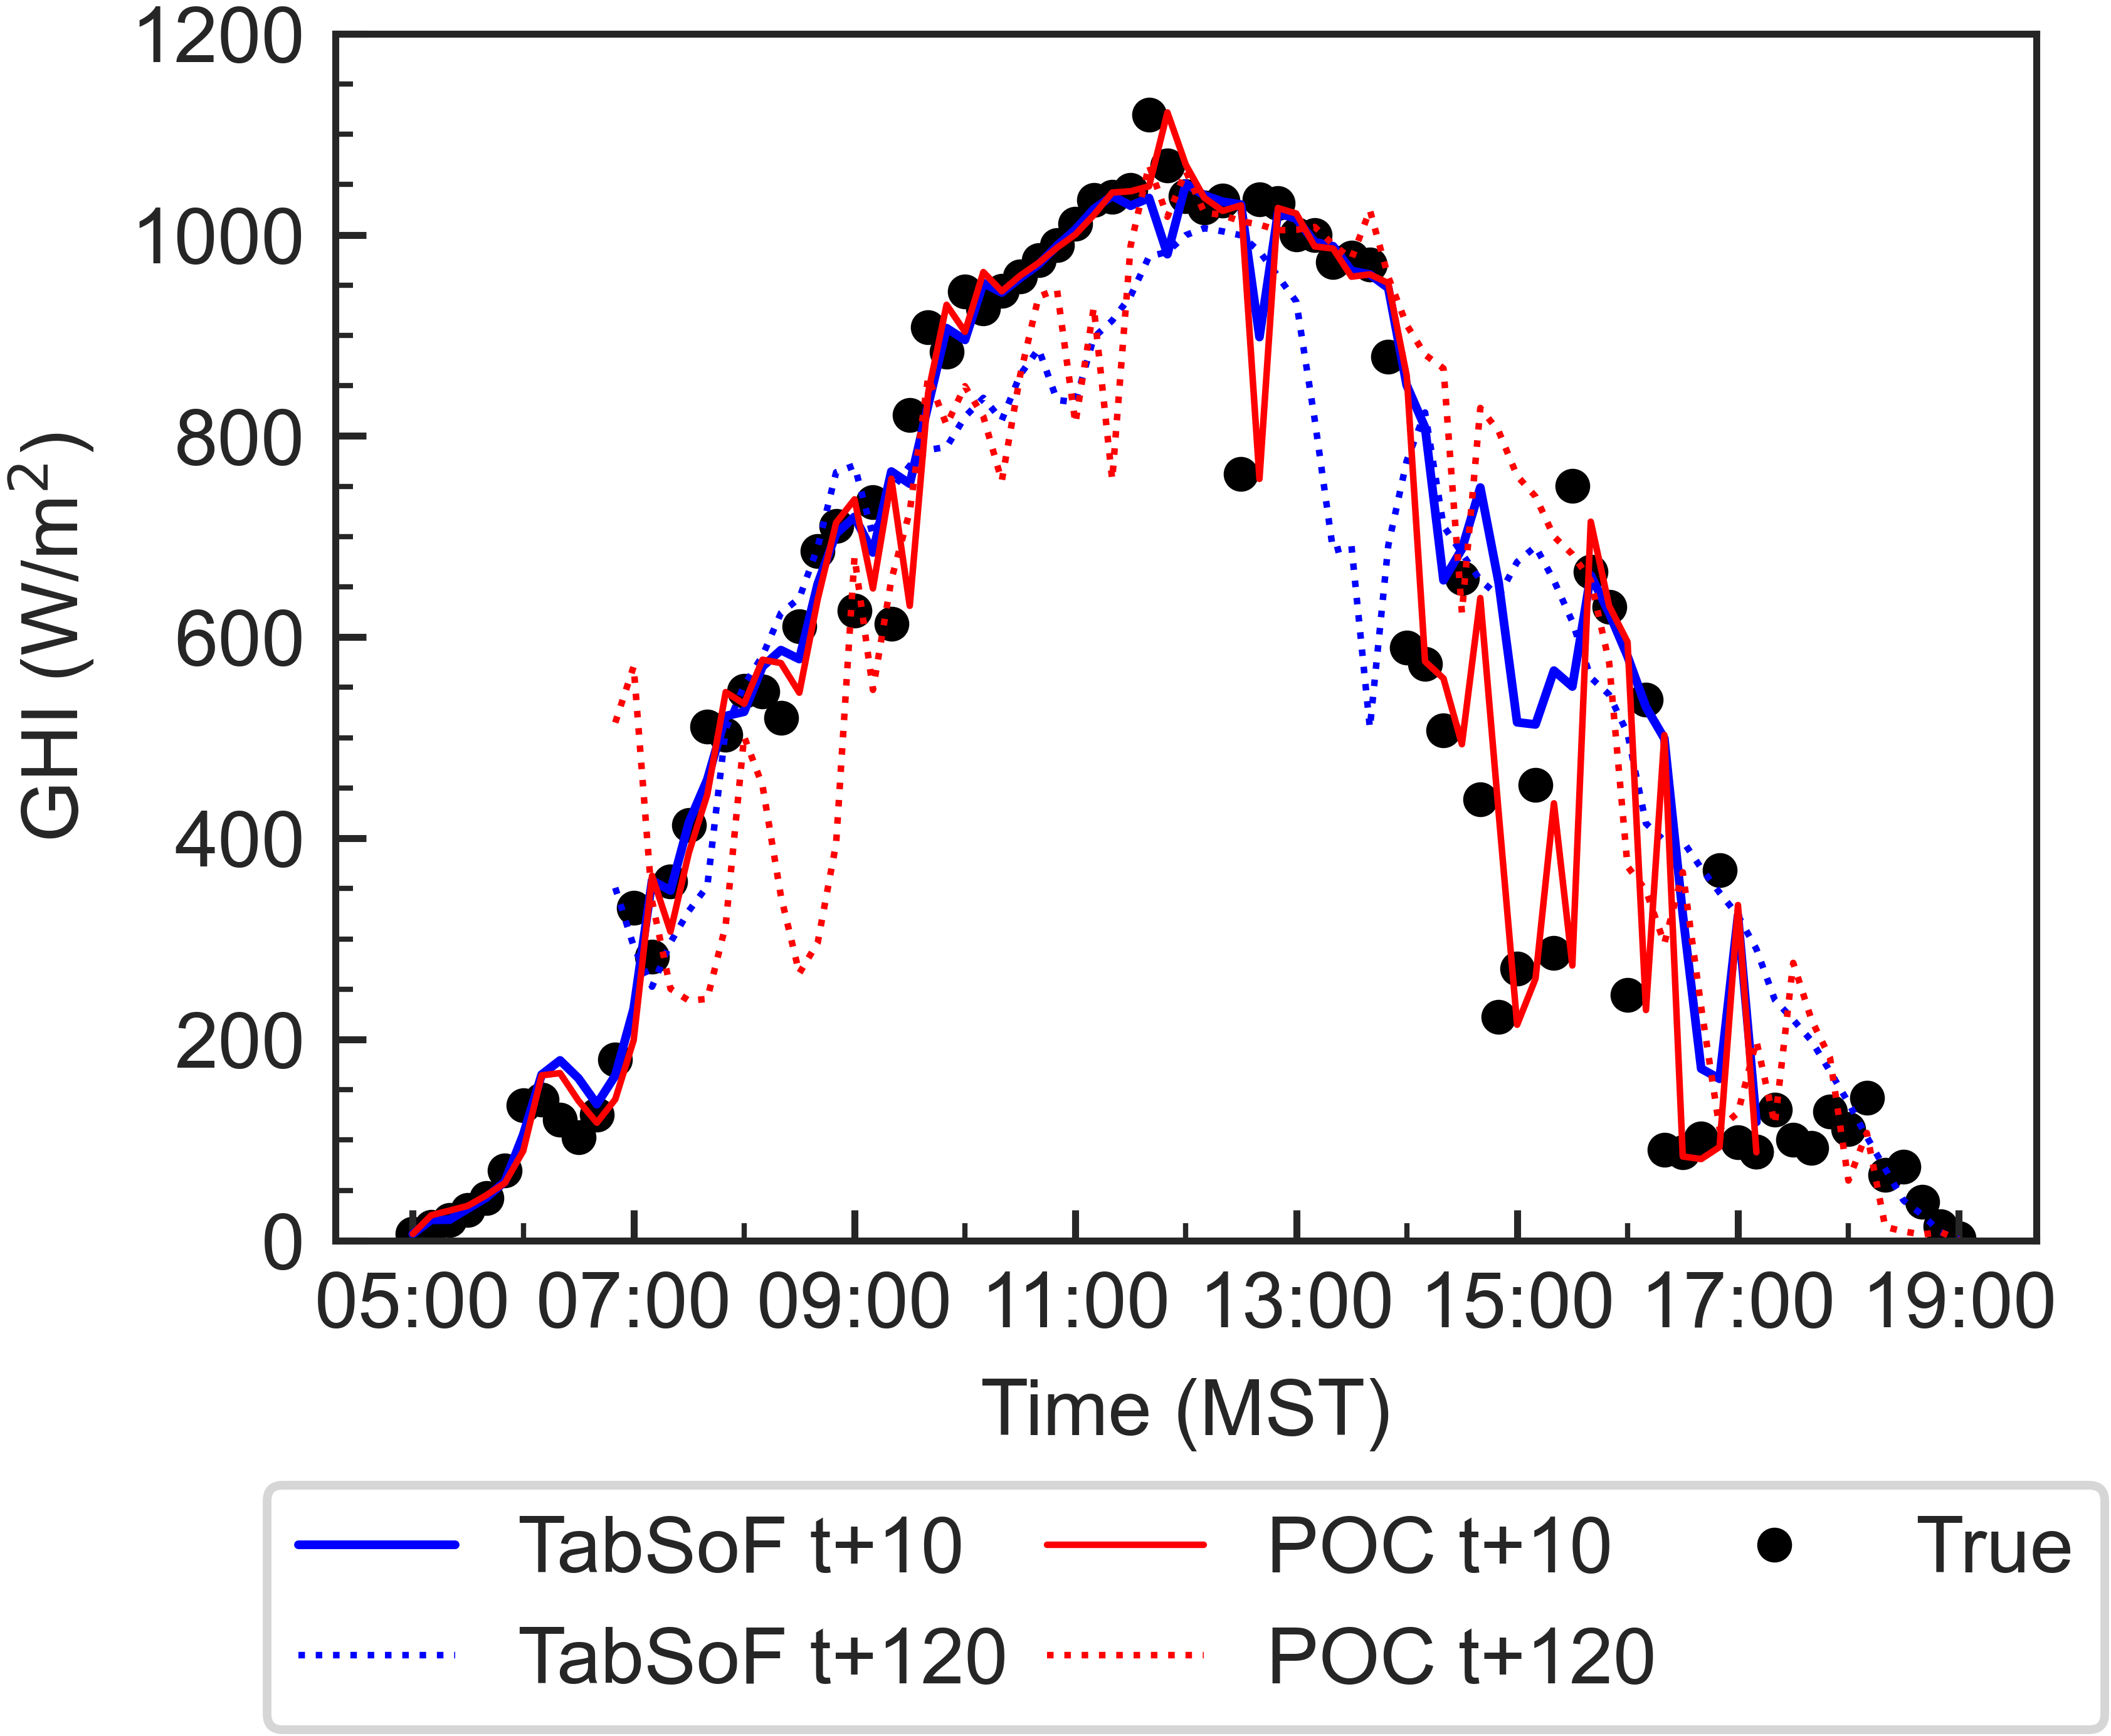

In [4]:
y_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
yp_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y_pred.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
persistence = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    * tt.validate_clear_sky_irradiances[:, 1:]
)
# y_rescaled = tt.rescale_to_GHI(y, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# yp_rescaled = tt.rescale_to_GHI(y_pred, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# persistence = tt.validate_clear_sky_indexes[:,0][:,None] * tt.validate_clear_sky_irradiances[:,1:]
# graph
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
ax.plot(
    tt.validate_dates[:, 1], yp_rescaled[:, 0], "b-", linewidth=1.0, label="TabSoF t+10"
)
ax.plot(
    tt.validate_dates[:, -1],
    yp_rescaled[:, -1],
    "b:",
    linewidth=0.75,
    label="TabSoF t+120",
)
ax.plot(
    tt.validate_dates[:, 1], persistence[:, 0], "r-", linewidth=0.75, label="POC t+10"
)
ax.plot(
    tt.validate_dates[:, -1],
    persistence[:, -1],
    "r:",
    linewidth=0.75,
    label="POC t+120",
)
ax.plot(tt.validate_dates[:, 1], y_rescaled[:, 0], "k.", zorder=0, label="True")
ax.plot(tt.validate_dates[-1, 1:], y_rescaled[-1, :], "k.", zorder=0)

ax.set_ylabel(r"GHI (W/m$^2$)")
ax.set_xlabel("Time (MST)")

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.17),
    # fancybox=True, shadow=True,
    ncol=3,
    columnspacing=0.5,
)
ax.set_ylim(0, 1200)
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_formatter(DateFormatter("%H:%M", tz=data_df.index.tz))
ax.xaxis.set_major_locator(md.HourLocator(byhour=range(5, 21, 2), tz=data_df.index.tz))
ax.xaxis.set_minor_locator(md.HourLocator(byhour=range(5, 21, 1), tz=data_df.index.tz))

fig.savefig("Reports/Images/predicted_day.pdf", dpi=1000, bbox_inches="tight")

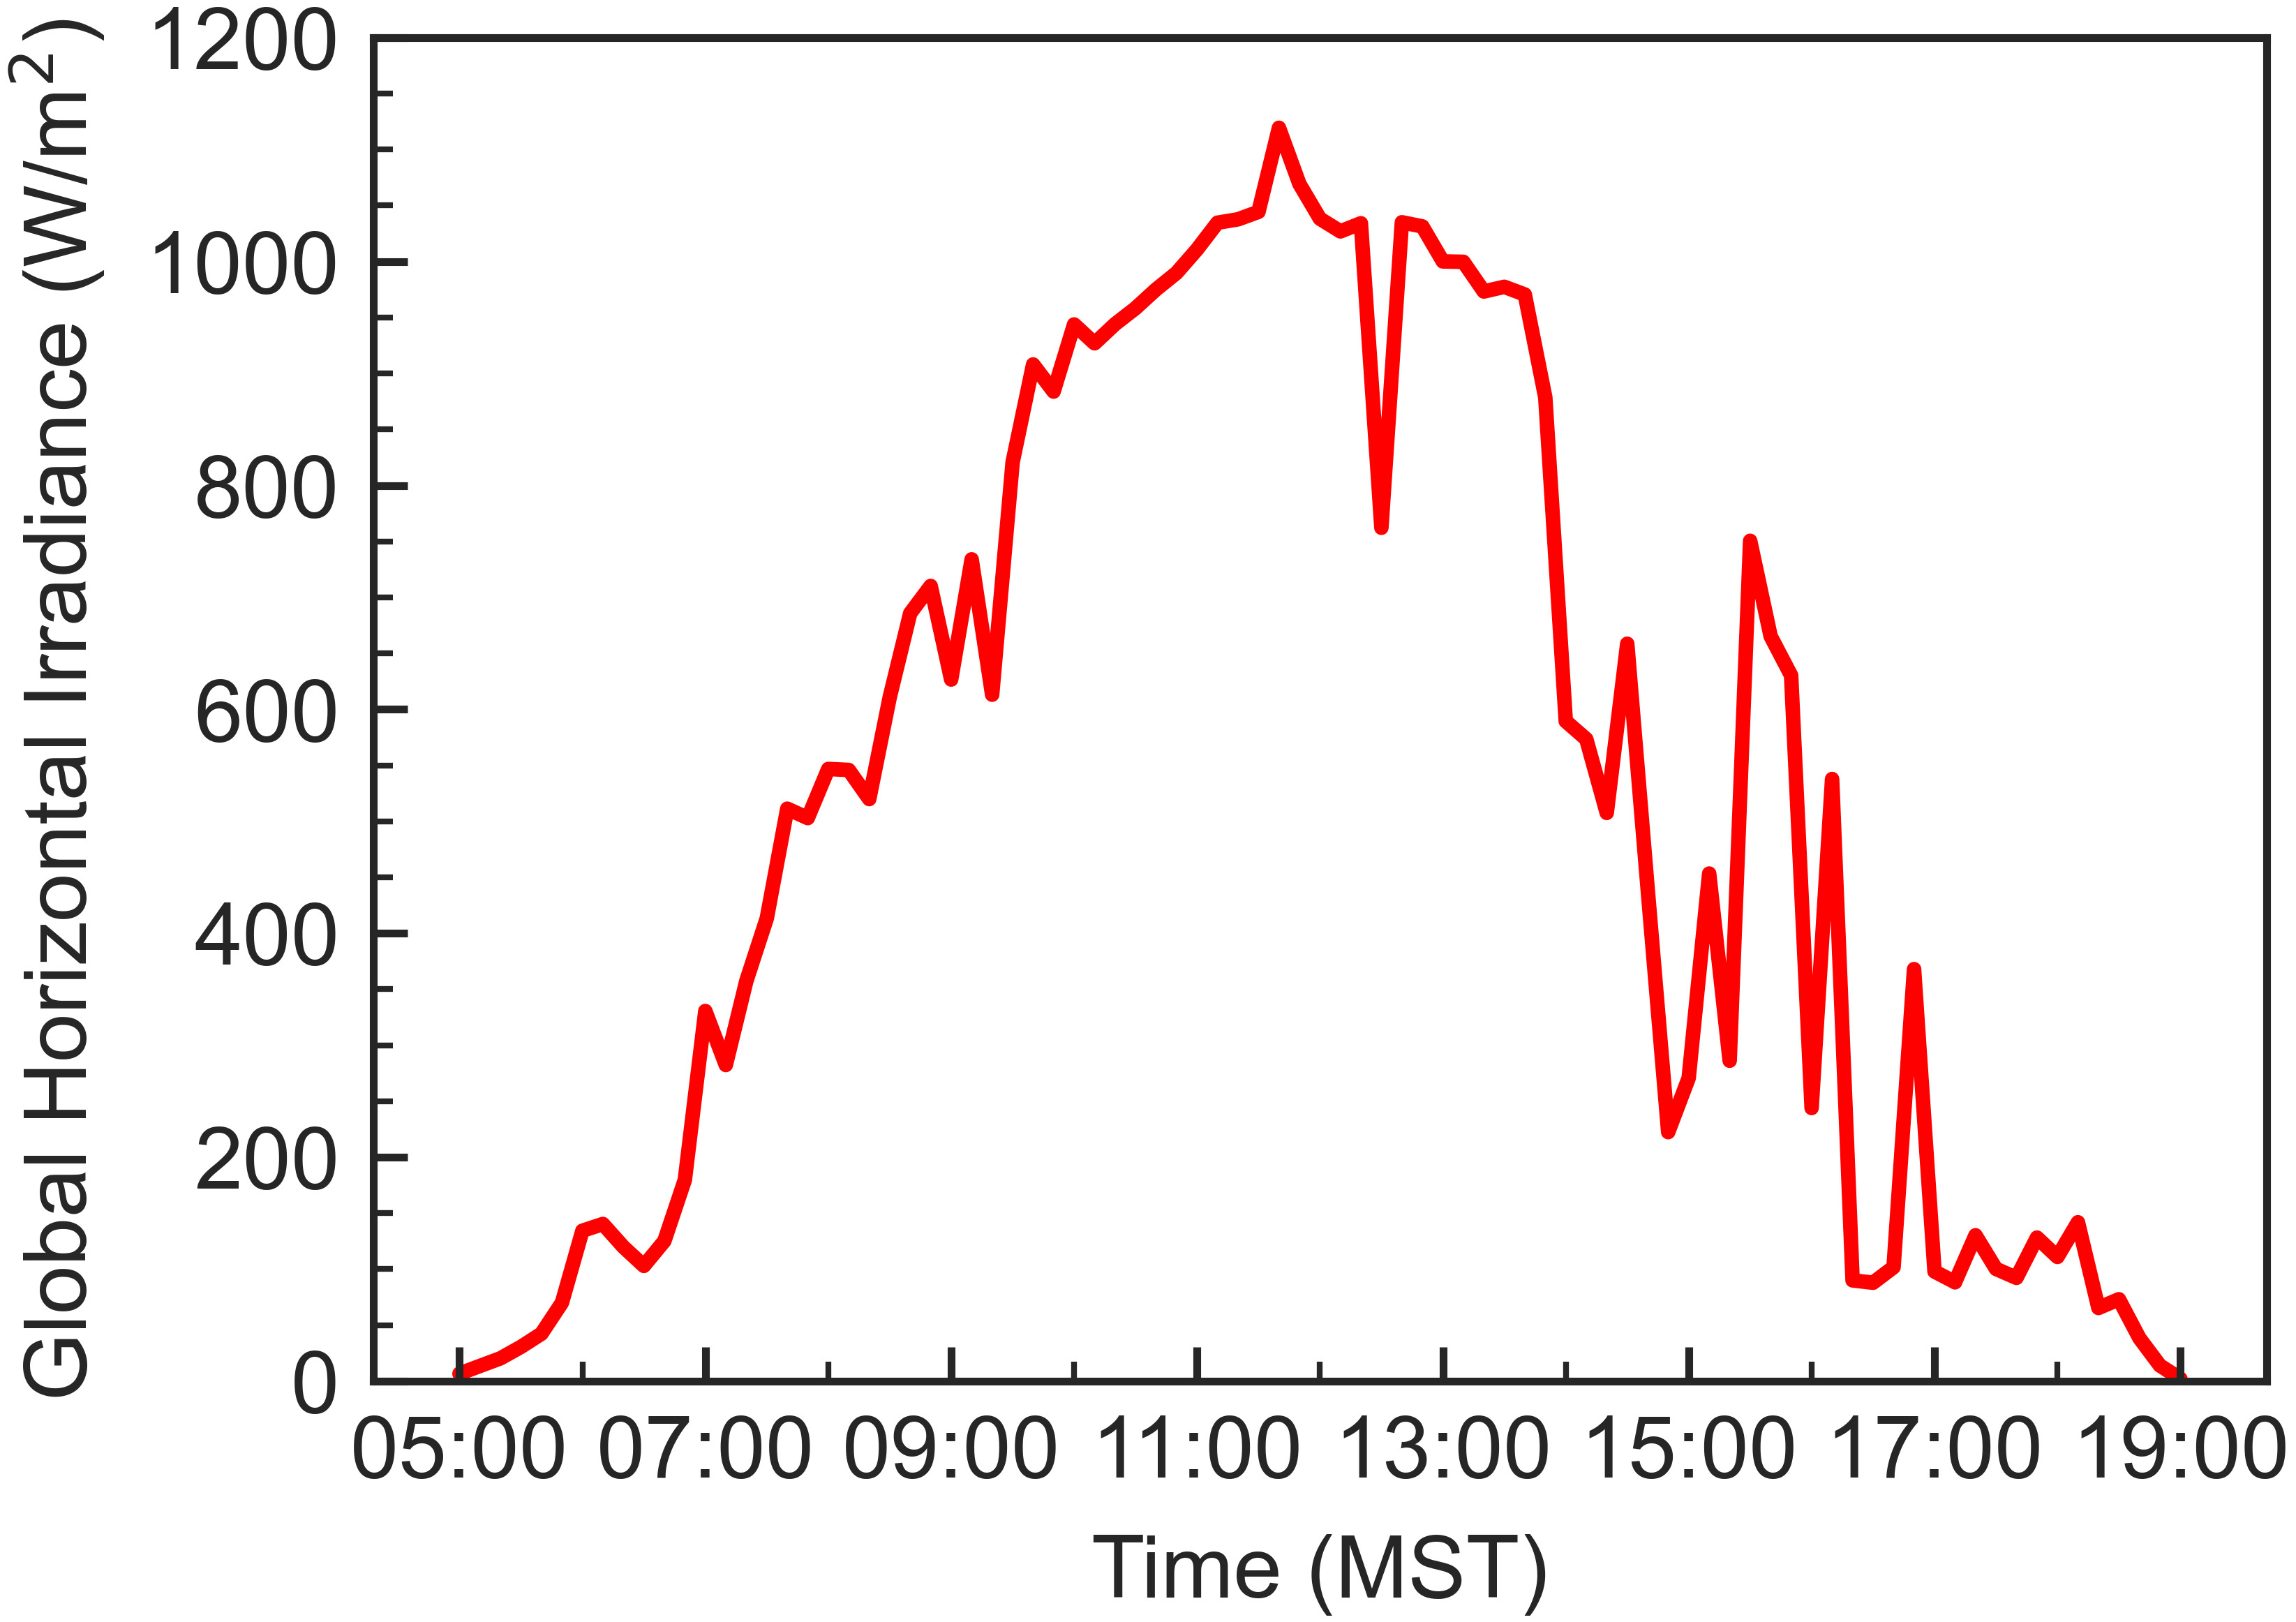

In [21]:
y_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
yp_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y_pred.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
persistence = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    * tt.validate_clear_sky_irradiances[:, 1:]
)
# y_rescaled = tt.rescale_to_GHI(y, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# yp_rescaled = tt.rescale_to_GHI(y_pred, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# persistence = tt.validate_clear_sky_indexes[:,0][:,None] * tt.validate_clear_sky_irradiances[:,1:]
# graph
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
# ax.plot(tt.validate_dates[:,1], yp_rescaled[:,0], "b-", linewidth=1.0, label="TabSoF t+10")
# ax.plot(tt.validate_dates[:,-1], yp_rescaled[:,-1], "b:", linewidth=0.75, label="TabSoF t+120")
# ax.plot(tt.validate_dates[:,1], persistence[:,0], "r-", linewidth=0.75, label="POC t+10")
# ax.plot(tt.validate_dates[:,-1], persistence[:,-1], "r:", linewidth=0.75, label="POC t+120")
ax.plot(tt.validate_dates[:, 1], y_rescaled[:, 0], "r-", zorder=0, label="True")
ax.plot(tt.validate_dates[-1, 1:], y_rescaled[-1, :], "r-", zorder=0)

ax.set_ylabel(r"Global Horizontal Irradiance (W/m$^2$)")
ax.set_xlabel("Time (MST)")

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
#         #fancybox=True, shadow=True,
#         ncol=3, columnspacing=0.5)
ax.set_ylim(0, 1200)
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_formatter(DateFormatter("%H:%M", tz=data_df.index.tz))
ax.xaxis.set_major_locator(md.HourLocator(byhour=range(5, 21, 2), tz=data_df.index.tz))
ax.xaxis.set_minor_locator(md.HourLocator(byhour=range(5, 21, 1), tz=data_df.index.tz))

fig.savefig("Reports/Images/abstract_ghi.pdf", dpi=1000, bbox_inches="tight")

In [56]:
print(
    f"Model MAE: {utils.MAE(y_rescaled, yp_rescaled), utils.MAE(y_rescaled, yp_rescaled, axis=0)}"
)
print(
    f"Persistence MAE: {utils.MAE(y_rescaled, persistence), utils.MAE(y_rescaled, persistence, axis=0)}"
)

Model MAE: (113.54121513874074, array([ 77.1868239 ,  92.88111975, 104.88157027, 110.15535201,
       111.27962618, 117.14609193, 118.07444192, 125.05272662,
       125.39218434, 124.27589375, 126.62843238, 129.54031861]))
Persistence MAE: (121.72010062578892, array([ 79.85592939,  89.68130841, 110.97156454, 107.84770532,
       129.28466033, 116.09109033, 129.46620323, 137.90269989,
       143.03510001, 137.34383262, 139.68136042, 139.47975302]))


In [5]:
tt.import_preprocess_cached_windows(
    train_validate_date="2022-01-20", end_date="2022-01-21", verbose=False
)
# create model
model = tf.keras.models.load_model(os.path.join("results", model_name))
# run inference
x = tt.validate_past_features
y = tt.y_validate_true

y_pred = model.predict(x)

y_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
yp_rescaled = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    + tt.response_scaler.inverse_transform(y_pred.squeeze())
) * tt.validate_clear_sky_irradiances[:, 1:]
persistence = (
    tt.validate_clear_sky_indexes[:, 0][:, None]
    * tt.validate_clear_sky_irradiances[:, 1:]
)
# graph
plt.plot(tt.validate_dates, y_rescaled, "k.", label="True")
plt.plot(tt.validate_dates[:, 1], yp_rescaled[:, 0], "r-", label="Predicted")
plt.plot(tt.validate_dates[:, 1], persistence[:, 0], "b:", label="Persistence")

NameError: name 'tt' is not defined

## Images for Graphical Abstract


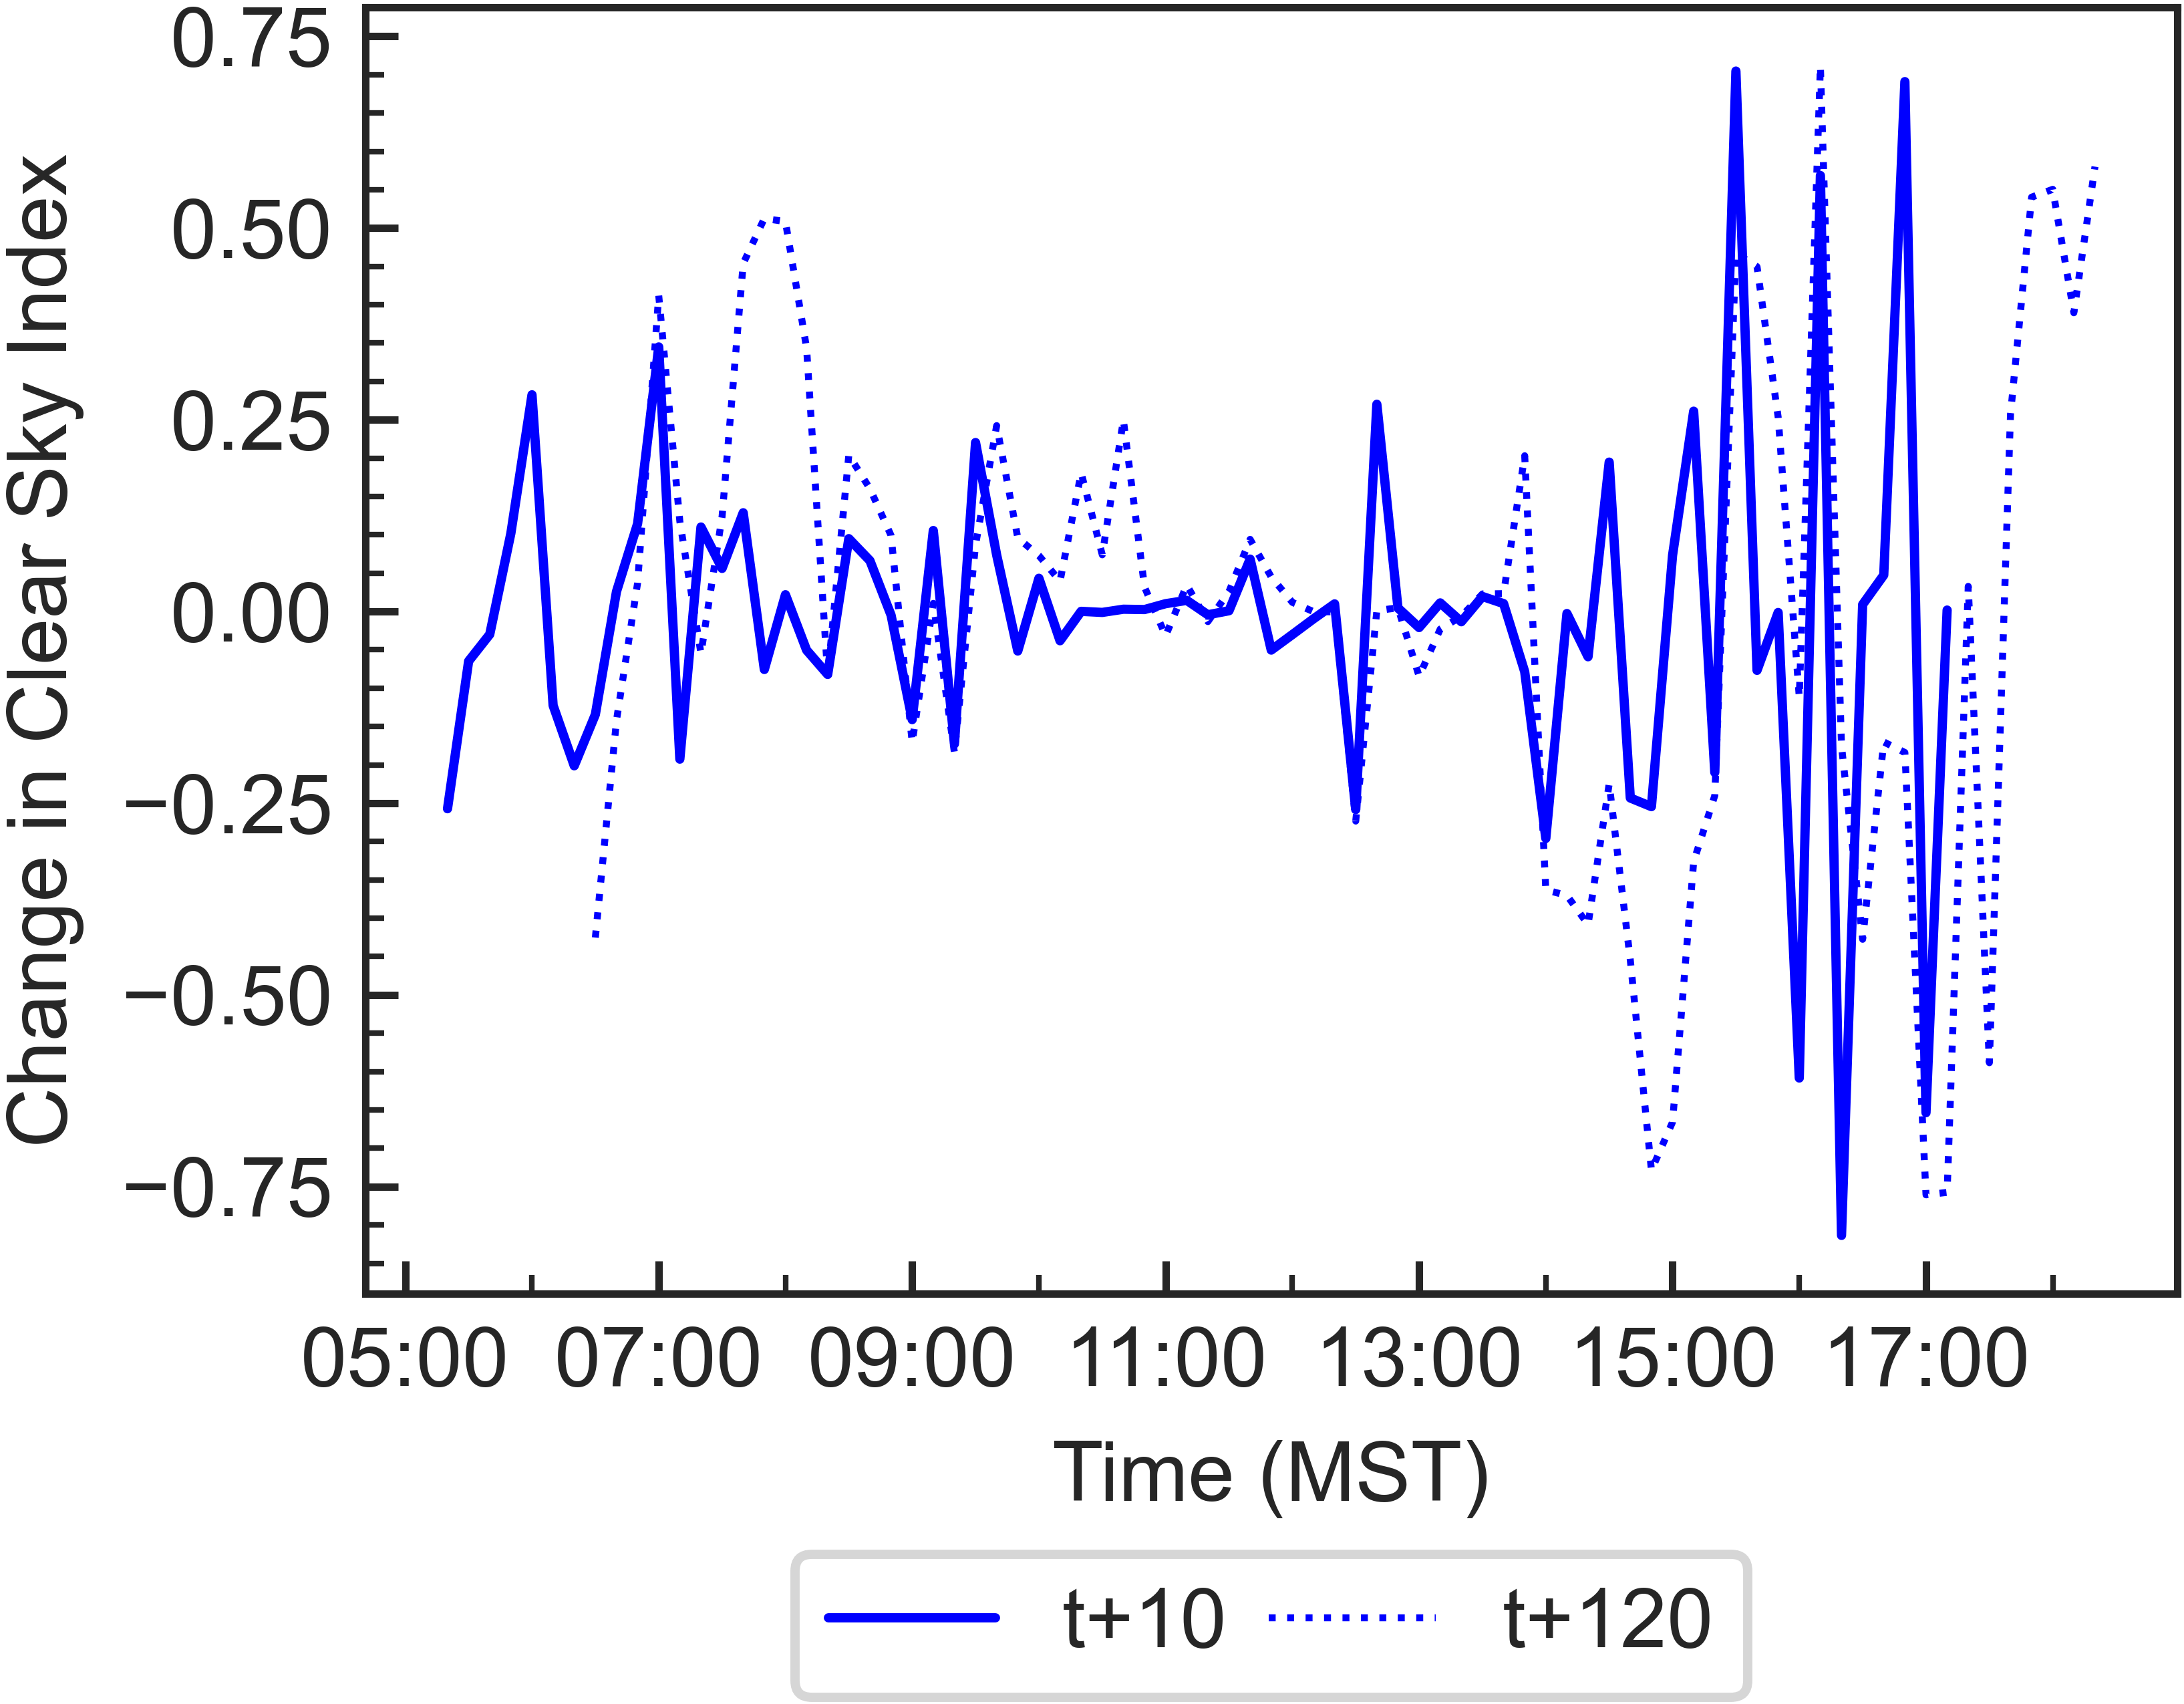

In [15]:
# y_rescaled = (tt.validate_clear_sky_indexes[:,0][:,None] + tt.response_scaler.inverse_transform(y.squeeze())) * tt.validate_clear_sky_irradiances[:,1:]
delta_csi = (
    tt.validate_clear_sky_indexes[:, 1:] - tt.validate_clear_sky_indexes[:, 0][:, None]
)
# persistence = tt.validate_clear_sky_indexes[:,0][:,None] * tt.validate_clear_sky_irradiances[:,1:]
# y_rescaled = tt.rescale_to_GHI(y, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# yp_rescaled = tt.rescale_to_GHI(y_pred, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes)
# persistence = tt.validate_clear_sky_indexes[:,0][:,None] * tt.validate_clear_sky_irradiances[:,1:]
# graph
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
ax.plot(tt.validate_dates[2:, 1], delta_csi[2:, 0], "b-", linewidth=1.0, label="t+10")
ax.plot(
    tt.validate_dates[2:, -5], delta_csi[2:, -5], "b:", linewidth=0.75, label="t+120"
)
# ax.plot(tt.validate_dates[:,1], y_rescaled[:,0], "k.", zorder=0, label="True")
# ax.plot(tt.validate_dates[-1,1:], y_rescaled[-1,:], "k.", zorder=0)

ax.set_ylabel(r"Change in Clear Sky Index")
ax.set_xlabel("Time (MST)")

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.17),
    # fancybox=True, shadow=True,
    ncol=3,
    columnspacing=0.5,
)
# ax.set_ylim(0,1200)
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_formatter(DateFormatter("%H:%M", tz=data_df.index.tz))
ax.xaxis.set_major_locator(md.HourLocator(byhour=range(5, 21, 2), tz=data_df.index.tz))
ax.xaxis.set_minor_locator(md.HourLocator(byhour=range(5, 21, 1), tz=data_df.index.tz))

fig.savefig("Reports/Images/abstract_deltacsi.pdf", dpi=1000, bbox_inches="tight")

## Calibration plots

### persistence of Cloudiness


In [6]:
# get model results
model_id = "SOL-210"
filename = model_id + "_CV1_residuals.h5"
experiment_path = os.path.join(constants.SOLARPROPHET_PATH, "results", filename)

with h5py.File(experiment_path, "r") as f:
    train_intermediate = f["train"]
    test_intermediate = f["validate"]
    results_intermediate = [train_intermediate, test_intermediate]
    results = [
        np.array([i["true"], i["predicted"], i["persistence"]])
        for i in results_intermediate
    ]
true, predicted, persistence = results[1]
print(results[0].shape)
print(true.shape)
train_len = results[0].shape[1]
validation_len = true.shape[0]
print("Prediction Validation MAE")
print(utils.MAE(true, predicted, axis=0), utils.MAE(true, predicted))
print("Persistence Validation MAE")
print(utils.MAE(true, persistence, axis=0), utils.MAE(true, persistence))

validation_count = 13147
val_total_persistence_mae = utils.MAE(
    true[-validation_count:], persistence[-validation_count:], axis=0
)
val_total_persistence_mae

(3, 65727, 12)
(13147, 12)
Prediction Validation MAE
[44.56070903 55.01571024 62.18991439 67.91756937 73.20994923 77.67225943
 80.71355761 83.37356419 86.13742318 88.7503518  90.55273249 92.36138882] 75.20459414908079
Persistence Validation MAE
[ 99.57851479 105.32686204 113.80732162 120.9679304  128.73175396
 134.48275967 139.06336434 146.15122254 150.59897058 154.5041635
 157.60757229 161.33745   ] 134.3464904781749


array([ 99.57851479, 105.32686204, 113.80732162, 120.9679304 ,
       128.73175396, 134.48275967, 139.06336434, 146.15122254,
       150.59897058, 154.5041635 , 157.60757229, 161.33745   ])

In [7]:
cmap = cm.get_cmap("viridis_r")
cmap2 = cm.get_cmap("plasma_r")

data_min = 1e-6
data_max = 17e-6
n_levels = 17
nondimensional_levels = np.linspace(0, 1, n_levels)
kde_densities = np.linspace(data_min, data_max, n_levels)  # densities used for colorbar
normalizer = Normalize(vmin=data_min, vmax=data_max)  # scales the colors used

C:\Users\jhamm\AppData\Local\Temp\ipykernel_24148\2975464817.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis_r")
C:\Users\jhamm\AppData\Local\Temp\ipykernel_24148\2975464817.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("plasma_r")


C:\Users\jhamm\AppData\Local\Temp\ipykernel_24148\2585600506.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.91,1])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


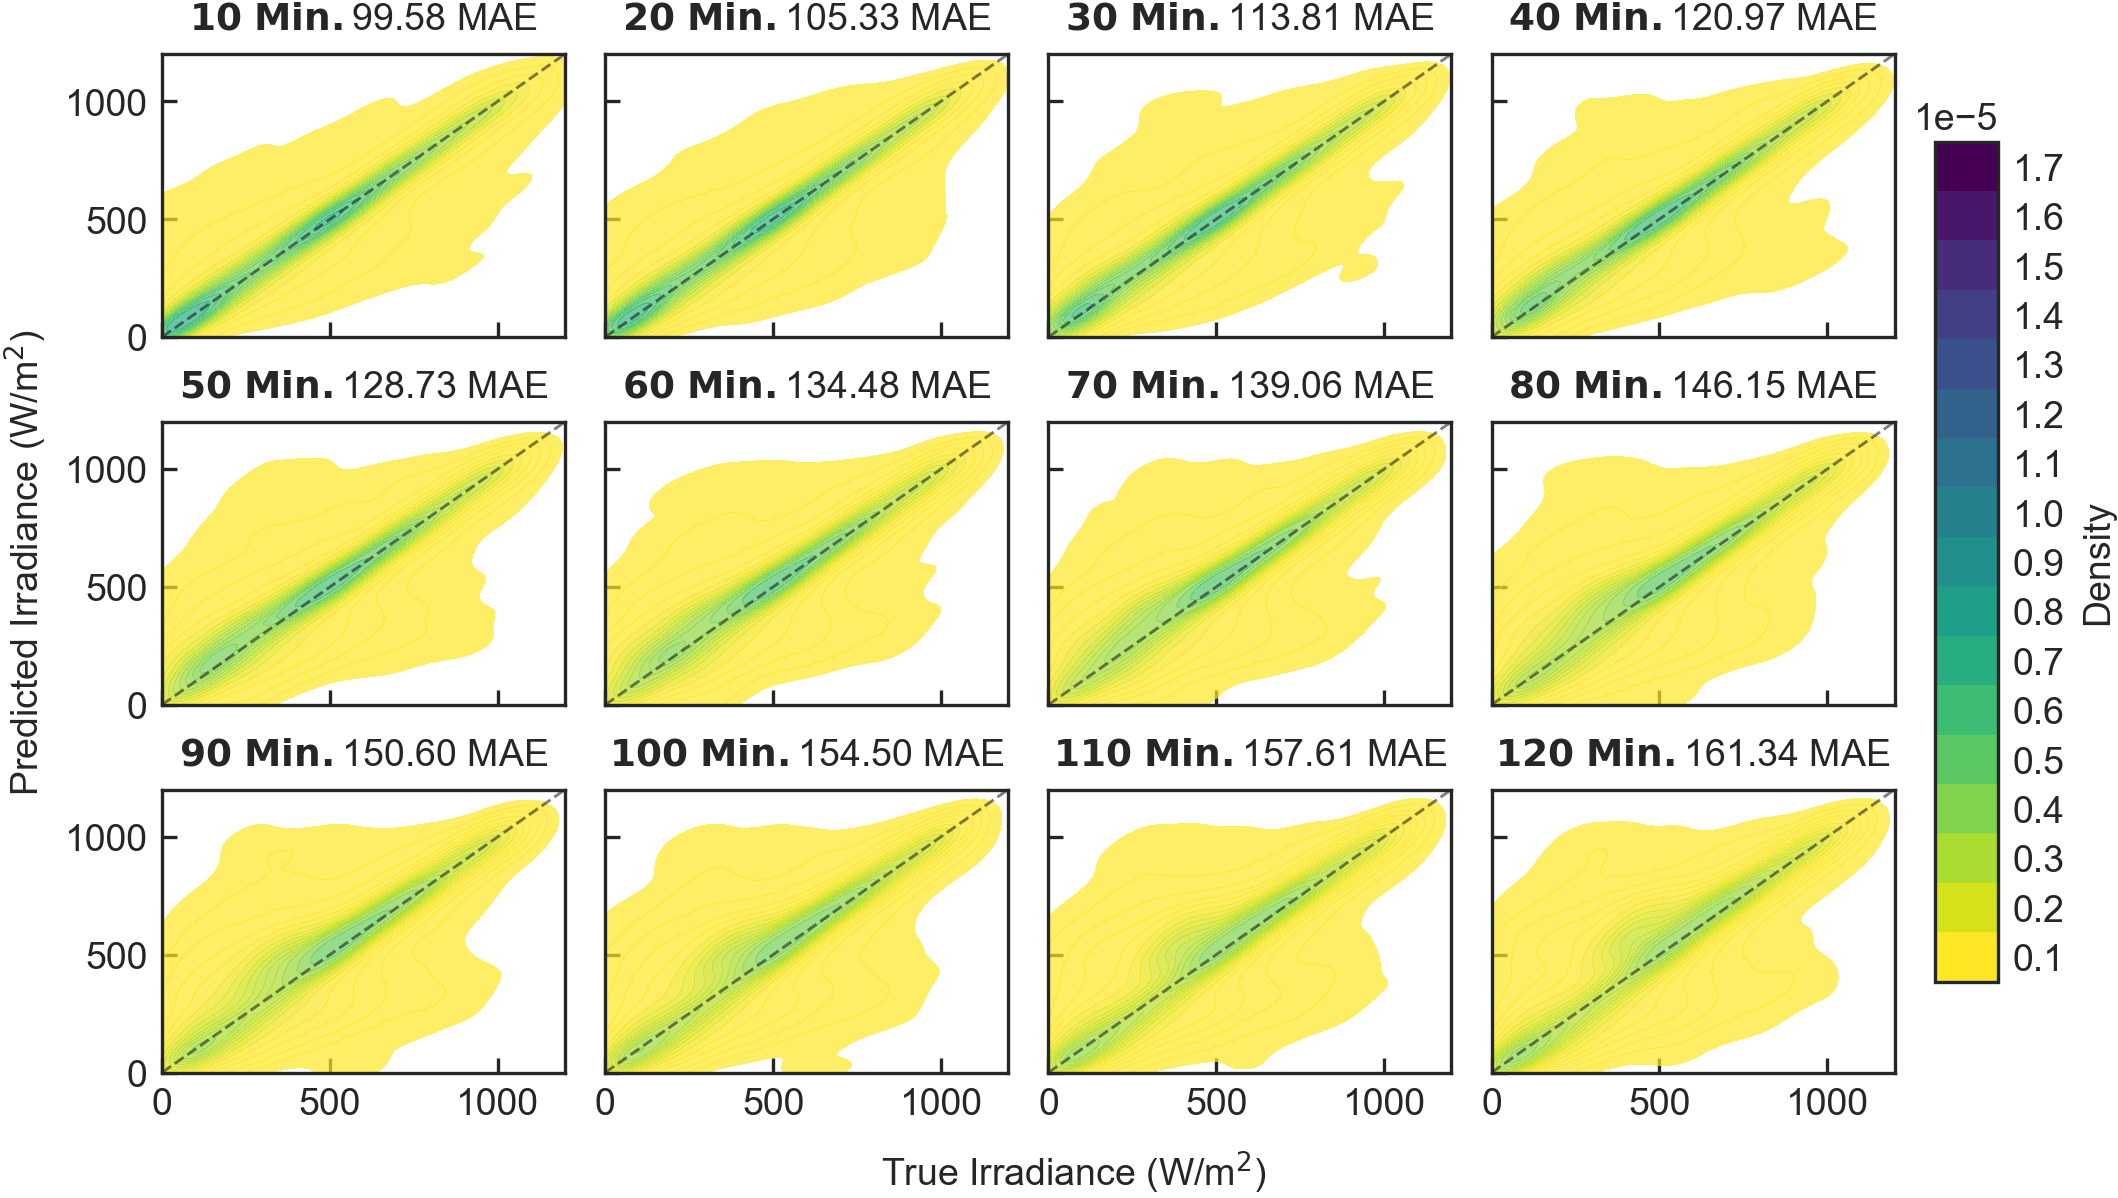

In [8]:
if 1:
    fig, axes = plt.subplots(3, 4, figsize=(7, 4), sharex=True, sharey=True, dpi=300)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])

    for i, ax in enumerate(axes.flatten()):
        time_ahead = 10 + i * 10
        im = sns.kdeplot(
            x=true[-validation_count:, i],
            y=persistence[-validation_count:, i],
            fill=True,
            cmap=cmap,
            ax=ax,
            common_norm=False,
            norm=normalizer,
            levels=nondimensional_levels[1:],
            alpha=0.7,
        )
        ax.plot(
            [0, 1200],
            [0, 1200],
            color="black",
            linestyle="--",
            linewidth=0.7,
            alpha=0.5,
        )
        ax.set_xlim([0, 1200])
        ax.set_ylim([0, 1200])
        ax.set_title(
            rf"$\bf{{{time_ahead}\ Min.}}${val_total_persistence_mae[i]:.2f} MAE",
            size=9,
        )
        # ax.grid(True, linestyle="-", color="gray", alpha=0.25)
        # ax.text(300, 1100, "Overprediction", horizontalalignment="center", size=12)
        # ax.text(850, 100, "Underprediction", horizontalalignment="center", size=12)

    fig.colorbar(
        cm.ScalarMappable(norm=normalizer, cmap=cmap),
        label="Density",
        cax=cbar_ax,
        ticks=kde_densities,
        values=kde_densities,
    )

    fig.tight_layout(rect=[0, 0, 0.91, 1])
    fig.text(0.5, -0.02, r"True Irradiance (W/m$^2$)", ha="center")
    fig.text(
        -0.01, 0.5, r"Predicted Irradiance (W/m$^2$)", va="center", rotation="vertical"
    )
    fig.subplots_adjust(wspace=0.1)
    fig.subplots_adjust(hspace=0.3)

    fig.savefig(
        os.path.join("Reports", "Images", "persistence_kde.png"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "persistence_kde.svg"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "persistence_kde.eps"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "persistence_kde.pdf"),
        bbox_inches="tight",
        dpi=1000,
    )
    plt.show()

### Prediction Calibration Plot

MAE


In [9]:
val_total_mae = utils.MAE(
    true[-validation_count:], predicted[-validation_count:], axis=0
)
val_total_mae, val_total_mae.mean()

(array([44.56070903, 55.01571024, 62.18991439, 67.91756937, 73.20994923,
        77.67225943, 80.71355761, 83.37356419, 86.13742318, 88.7503518 ,
        90.55273249, 92.36138882]),
 75.20459414908076)

C:\Users\jhamm\AppData\Local\Temp\ipykernel_24148\2025405729.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.91,1])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


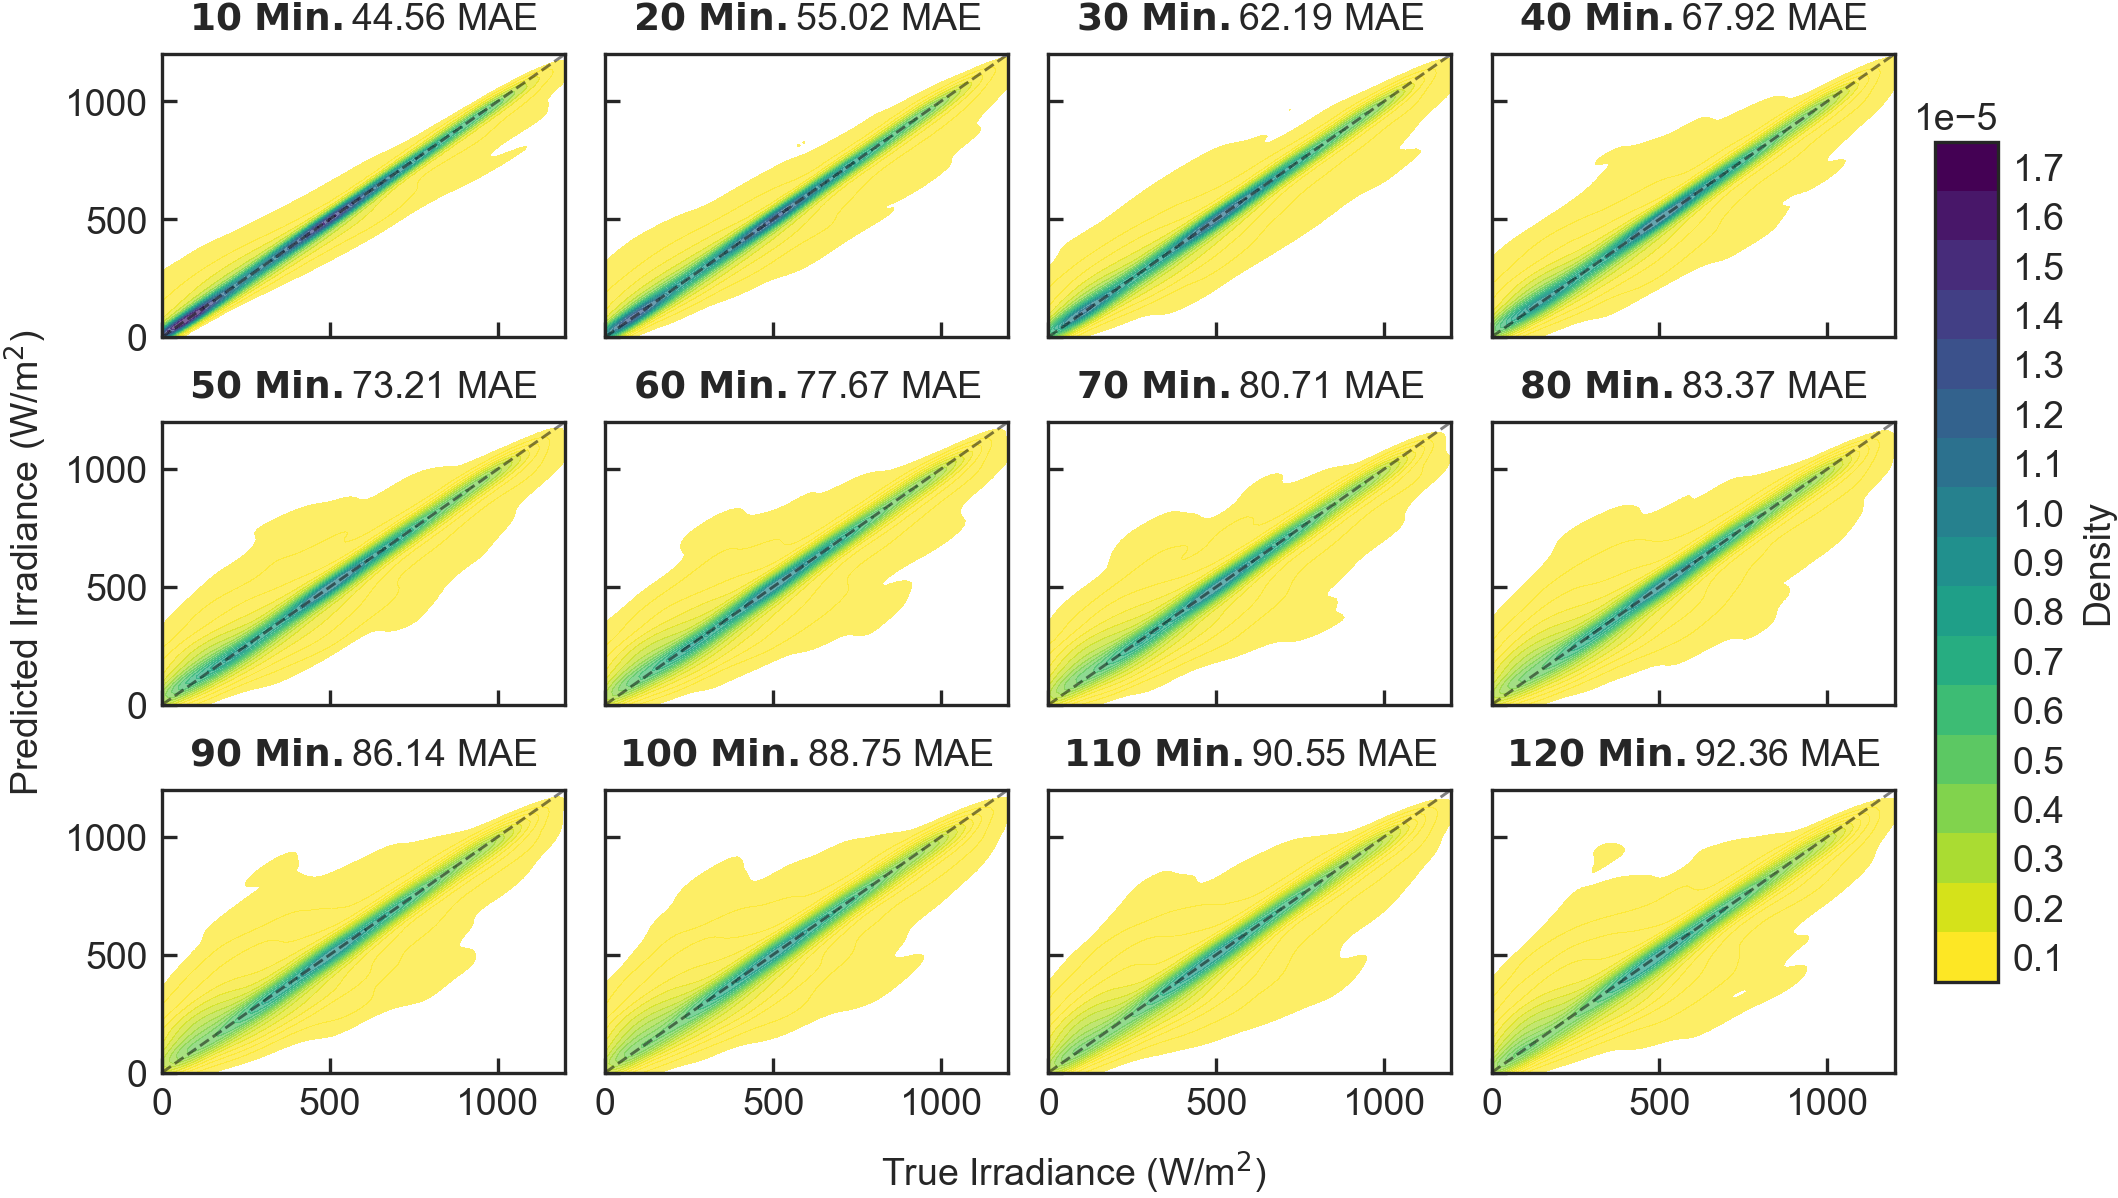

In [10]:
if 1:
    fig, axes = plt.subplots(3, 4, figsize=(7, 4), sharex=True, sharey=True, dpi=300)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])

    for i, ax in enumerate(axes.flatten()):
        time_ahead = 10 + i * 10
        im = sns.kdeplot(
            x=true[-validation_count:, i],
            y=predicted[-validation_count:, i],
            fill=True,
            cmap=cmap,
            ax=ax,
            common_norm=False,
            norm=normalizer,
            levels=nondimensional_levels[1:],
            alpha=0.7,
        )
        ax.plot(
            [0, 1200],
            [0, 1200],
            color="black",
            linestyle="--",
            linewidth=0.7,
            alpha=0.5,
        )
        ax.set_xlim([0, 1200])
        ax.set_ylim([0, 1200])
        ax.set_title(rf"$\bf{{{time_ahead}\ Min.}}${val_total_mae[i]:.2f} MAE", size=9)
        # ax.grid(True, linestyle="-", color="gray", alpha=0.25)
        # ax.text(300, 1100, "Overprediction", horizontalalignment="center", size=12)
        # ax.text(850, 100, "Underprediction", horizontalalignment="center", size=12)

    fig.colorbar(
        cm.ScalarMappable(norm=normalizer, cmap=cmap),
        label="Density",
        cax=cbar_ax,
        ticks=kde_densities,
        values=kde_densities,
    )

    fig.tight_layout(rect=[0, 0, 0.91, 1])
    fig.text(0.5, -0.02, r"True Irradiance (W/m$^2$)", ha="center")
    fig.text(
        -0.01, 0.5, r"Predicted Irradiance (W/m$^2$)", va="center", rotation="vertical"
    )
    fig.subplots_adjust(wspace=0.1)
    fig.subplots_adjust(hspace=0.3)

    fig.savefig(
        os.path.join("Reports", "Images", "predicted_kde.png"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "predicted_kde.svg"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "predicted_kde.eps"),
        bbox_inches="tight",
        dpi=1000,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "predicted_kde.pdf"),
        bbox_inches="tight",
        dpi=1000,
    )
    plt.show()

Both persistence and predicted


In [11]:
if 0:
    fig, axes = plt.subplots(3, 4, figsize=(13, 10), sharex=True, sharey=True, dpi=300)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])

    for i, ax in enumerate(axes.flatten()):
        time_ahead = 10 + i * 10
        im1 = sns.kdeplot(
            x=true[-validation_count:, i],
            y=persistence[-validation_count:, i],
            fill=False,
            color="lightblue",
            ax=ax,
            common_norm=False,
            norm=normalizer,
            levels=nondimensional_levels[1:],
            alpha=0.7,
            cbar=False,
        )
        im1 = sns.kdeplot(
            x=true[-validation_count:, i],
            y=predicted[-validation_count:, i],
            fill=False,
            color="orange",
            ax=ax,
            common_norm=False,
            norm=normalizer,
            levels=nondimensional_levels[1:],
            alpha=0.7,
            cbar=False,
        )
        ax.plot(
            [0, 1200],
            [0, 1200],
            color="black",
            linestyle="--",
            linewidth=0.7,
            alpha=0.5,
        )
        ax.set_xlim([0, 1200])
        ax.set_ylim([0, 1200])
        ax.set_title(rf"$\bf{{{time_ahead}\ Min.\ Ahead}}$")
        # ax.grid(True, linestyle="-", color="gray", alpha=0.25)
        ax.text(200, 1100, "Overprediction", horizontalalignment="center", size=8)
        ax.text(950, 100, "Underprediction", horizontalalignment="center", size=8)

    ax.legend(
        ["Persistence", "Predicted"], loc="lower left", bbox_to_anchor=(1.05, 1.0)
    )

    fig.tight_layout(rect=[0, 0, 0.91, 1])
    fig.text(0.5, 0.00, r"True Irradiance (W/m$^2$)", ha="center", size=12)
    fig.text(
        0.00,
        0.5,
        r"Persistence of Cloudiness Irradiance (W/m$^2$)",
        va="center",
        rotation="vertical",
        size=12,
    )
    fig.subplots_adjust(wspace=0.1)
    fig.subplots_adjust(hspace=0.1)

    fig.savefig(
        os.path.join("Reports", "Images", "compared_kde.png"),
        bbox_inches="tight",
        dpi=300,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "compared_kde.svg"),
        bbox_inches="tight",
        dpi=300,
    )
    fig.savefig(
        os.path.join("Reports", "Images", "compared_kde.eps"),
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()

RMSE


In [12]:
val_predicted_mae = utils.RMSE(
    true[-validation_count:], predicted[-validation_count:], axis=0
)
val_persistence_mae = utils.RMSE(
    true[-validation_count:], persistence[-validation_count:], axis=0
)
print(val_predicted_mae, val_persistence_mae)

[102.28543827 116.1005727  125.40127368 131.88632209 137.77703755
 142.41232366 145.17212883 148.76741666 152.53654275 155.82934489
 158.01935347 159.79955436] [237.25902884 228.57461036 233.93585071 237.02326823 242.9188458
 245.79251478 248.24762146 256.10199329 258.91095417 262.62710845
 266.09589311 270.22336974]


Forecast Skill Score


## Comparison with Literature


In [13]:
# Best Models and Literature

# get new neptune data
neptune_project = neptune.init_project(
    project=constants.NEPTUNE_PROJECT,
    api_token=constants.NEPTUNE_TOKEN,
    mode="read-only",
)
runs_table_df = neptune_project.fetch_runs_table().to_pandas()

model_runs = {
    "GHI": "SOL-96",
    "Delta CSI GHI": "SOL-192",
    "Delta GHI": "SOL-138",  # two points did not converge in first trial
    "cs_dev t ghi": "SOL-125",
    "CSI GHI": "SOL-109",
}

clipped_df = runs_table_df[runs_table_df["sys/id"].isin(model_runs.values())].copy()

MAE_train_cols = [f"CV 3: Train MAE t+{i+1}0 min" for i in range(12)]
MAE_validate_cols = [f"CV 3: Validate MAE t+{i+1}0 min" for i in range(12)]
MAE_validate_persistence_cols = [
    f"CV 3: Validate Persistence MAE t+{i+1}0 min" for i in range(12)
]
FS_train_cols = [f"CV 3: Train FS MAE t+{i+1}0 min" for i in range(12)]
FS_validate_cols = [f"CV 3: Validate FS MAE t+{i+1}0 min" for i in range(12)]

# clipped_df[["sys/id","selected responses","CV 3: Train MAE", "CV 3: Validate MAE"] + MAE_validate_persistence_cols]
clipped_df[
    ["sys/id", "selected responses", "CV 3: Train MAE", "CV 3: Validate MAE"]
    + MAE_validate_persistence_cols
]

# literature results
from data.literature_results import (
    Feng_2020,
    Feng_2022,
    Allaham_2020_TSI,
    Allaham_2020_ASI,
)

feng_2020_rmse = Feng_2020["results_rmse"].get(Feng_2020.get("best_model"))
feng_2022_rmse = Feng_2022["results_rmse"].get(Feng_2022.get("best_model"))
allaham_asi_rmse = Allaham_2020_ASI["results_rmse"].get(
    Allaham_2020_ASI.get("best_model")
)
allaham_tsi_rmse = Allaham_2020_TSI["results_rmse"].get(
    Allaham_2020_TSI.get("best_model")
)

feng_2022_fs = Feng_2022["results_fs"].get(Feng_2022.get("best_model"))
feng_2022_rmse

https://app.neptune.ai/HorizonPSE/SolarProphet-II/


array([[ 10.  ,  71.3 ],
       [ 20.  ,  98.53],
       [ 30.  , 109.33],
       [ 40.  , 119.35],
       [ 50.  , 127.49],
       [ 60.  , 135.43]])

In [14]:
runs_table_df[runs_table_df["sys/id"] == "SOL-192"]["selected features"]

37    ['TOD', 'TOY', 'DNI', 'DHI', 'ghi t-1', 'ghi t...
Name: selected features, dtype: object

In [15]:
prediction_mae = utils.MAE(
    true[-validation_count:], predicted[-validation_count:], axis=0
)
prediction_rmse = utils.RMSE(
    true[-validation_count:], predicted[-validation_count:], axis=0
)
persistence_mae = utils.MAE(
    true[-validation_count:], persistence[-validation_count:], axis=0
)
persistence_rmse = utils.RMSE(
    true[-validation_count:], persistence[-validation_count:], axis=0
)
fs_mae = 1 - prediction_mae / persistence_mae
fs_rmse = 1 - prediction_rmse / persistence_rmse
print(f"{prediction_mae=}")
print(f"{prediction_rmse=}")
print(f"{persistence_mae=}")
print(f"{persistence_rmse=}")

prediction_mae=array([44.56070903, 55.01571024, 62.18991439, 67.91756937, 73.20994923,
       77.67225943, 80.71355761, 83.37356419, 86.13742318, 88.7503518 ,
       90.55273249, 92.36138882])
prediction_rmse=array([102.28543827, 116.1005727 , 125.40127368, 131.88632209,
       137.77703755, 142.41232366, 145.17212883, 148.76741666,
       152.53654275, 155.82934489, 158.01935347, 159.79955436])
persistence_mae=array([ 99.57851479, 105.32686204, 113.80732162, 120.9679304 ,
       128.73175396, 134.48275967, 139.06336434, 146.15122254,
       150.59897058, 154.5041635 , 157.60757229, 161.33745   ])
persistence_rmse=array([237.25902884, 228.57461036, 233.93585071, 237.02326823,
       242.9188458 , 245.79251478, 248.24762146, 256.10199329,
       258.91095417, 262.62710845, 266.09589311, 270.22336974])


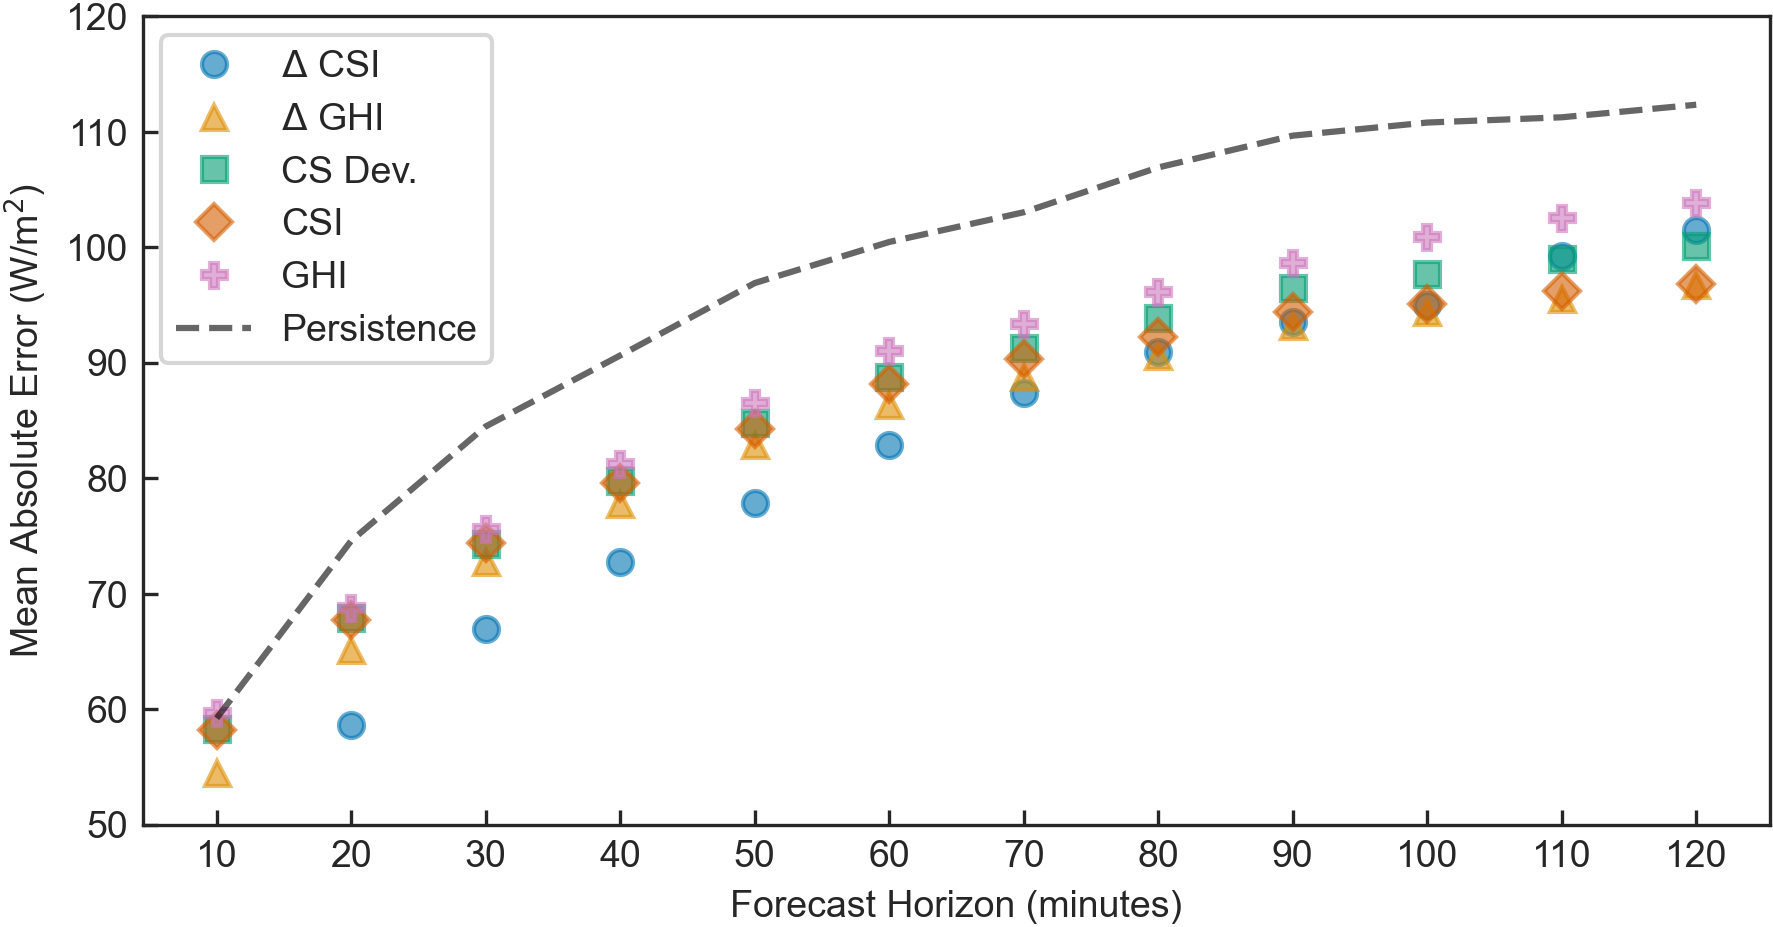

In [22]:
# MAE
x = np.arange(10, 130, 10)
y = clipped_df[MAE_validate_cols].values
yy = clipped_df[MAE_validate_persistence_cols].values[2]
labels = [
    constants.RESPONSE_FULL_NAMES.get(eval(i)[0])
    for i in clipped_df["selected responses"].values
]
labels = labels = [r"$\Delta$ CSI", r"$\Delta$ GHI", r"CS Dev.", r"CSI", r"GHI"]
markers = ["o", "^", "s", "D", "P"]

fig, ax = plt.subplots(figsize=(7, 3.5), dpi=300)
for i in range(len(y)):
    ax.plot(x, y[i], label=labels[i], marker=markers[i], linestyle="none", alpha=0.6)

ax.plot(x, yy, label="Persistence", color="black", linestyle="--", alpha=0.6)

ax.set_ylim(50, 120)
# ax.grid()
ax.set_ylabel(r"Mean Absolute Error (W/m$^2$)")
ax.set_xlabel(r"Forecast Horizon (minutes)")

x_ticks = np.arange(10, 130, 10)
ax.set_xticks(x_ticks)
ax.legend()

plt.show()

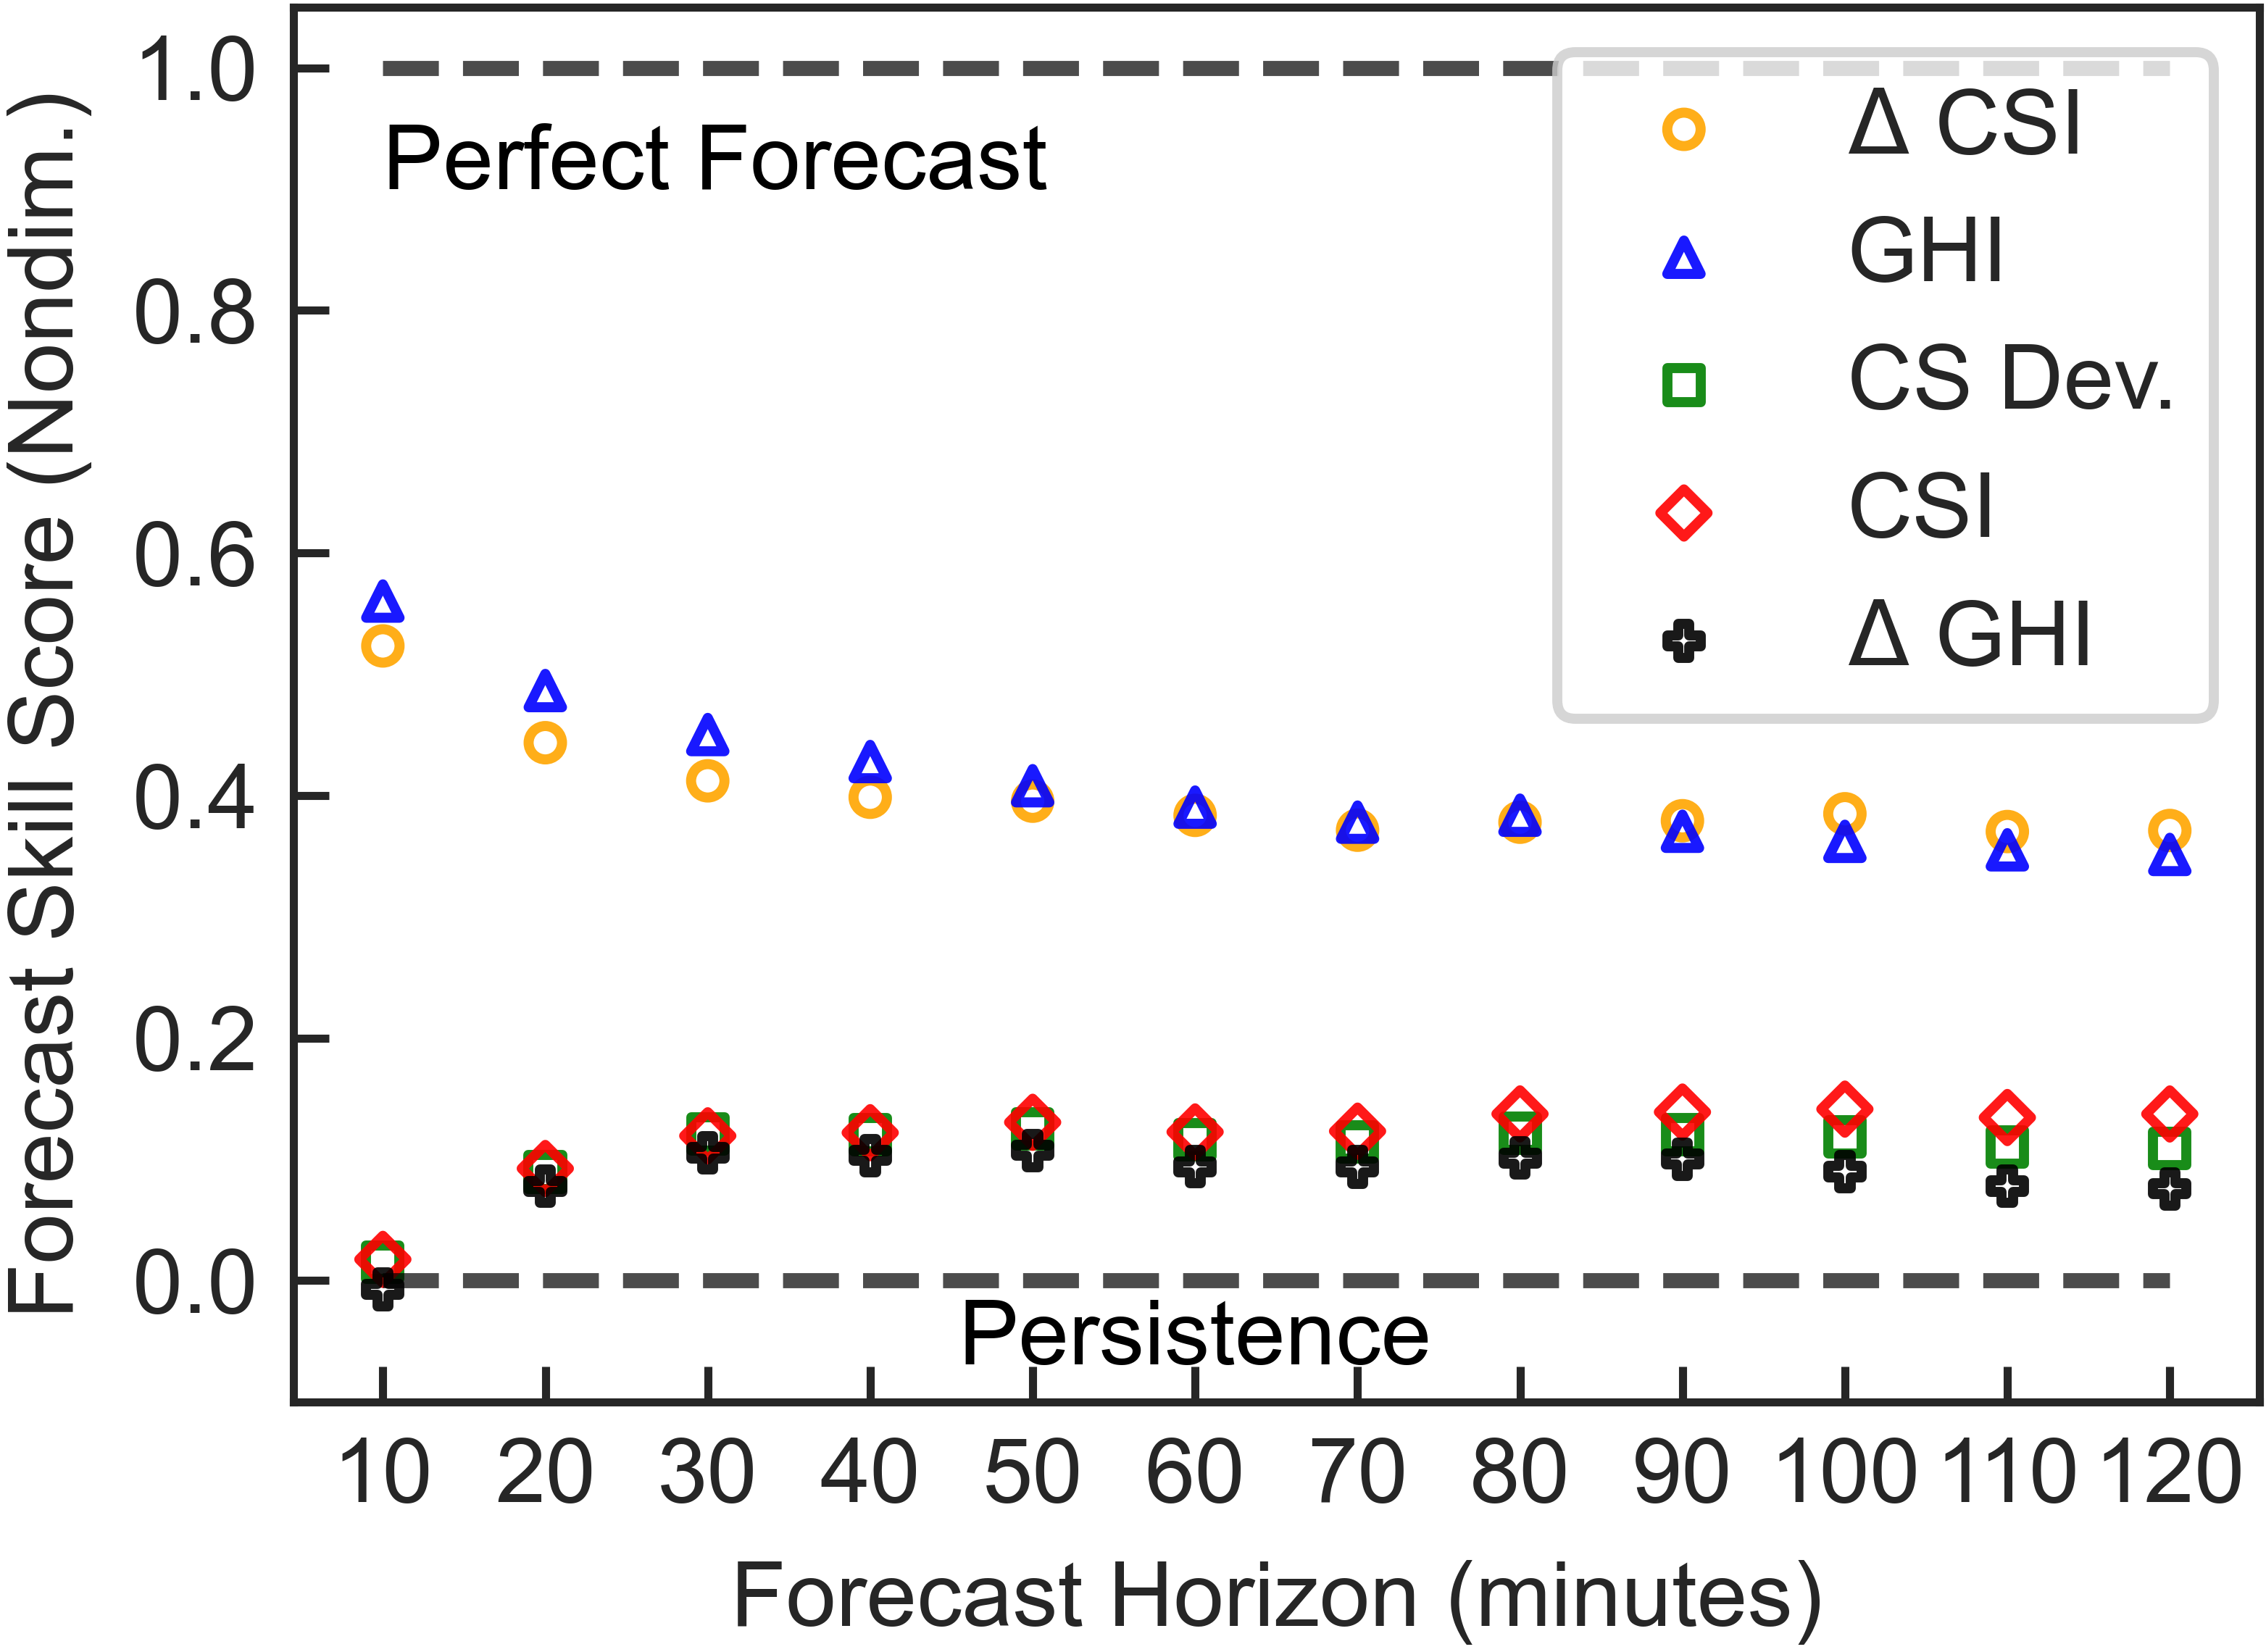

In [28]:
# MAE Forecst Skill
x = np.arange(10, 130, 10)
y = clipped_df[FS_validate_cols].values
labels = labels
labels = [r"$\Delta$ CSI", r"GHI", r"CS Dev.", r"CSI", r"$\Delta$ GHI"]

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=1000)
for i in range(len(y)):
    ax.scatter(
        x,
        y[i],
        label=labels[i],
        marker=markers[i],
        alpha=0.9,
        s=11,
        facecolors="none",
        edgecolors=["orange", "blue", "green", "red", "black"][i],
    )

ax.hlines([1, 0], 10, 120, linestyle="dashed", color="black", alpha=0.7)

# ax.grid()
ax.set_ylabel(r"Forecast Skill Score (Nondim.)")
ax.set_xlabel(r"Forecast Horizon (minutes)")

ax.text(10, 0.9, "Perfect Forecast", ha="left", color="black", alpha=1)
ax.text(60, -0.05, "Persistence", ha="center", va="center", color="black", alpha=1)

x_ticks = np.arange(10, 130, 10)
ax.set_xticks(x_ticks)
ax.set_ylim(-0.1, 1.05)
plt.legend()

fig.savefig(
    os.path.join("Reports", "Images", "forecast_skill.pdf"),
    bbox_inches="tight",
    dpi=1000,
)
# fig.savefig(os.path.join("Reports","Images", "forecast_skill.png"), bbox_inches='tight', dpi=1000)
plt.show()

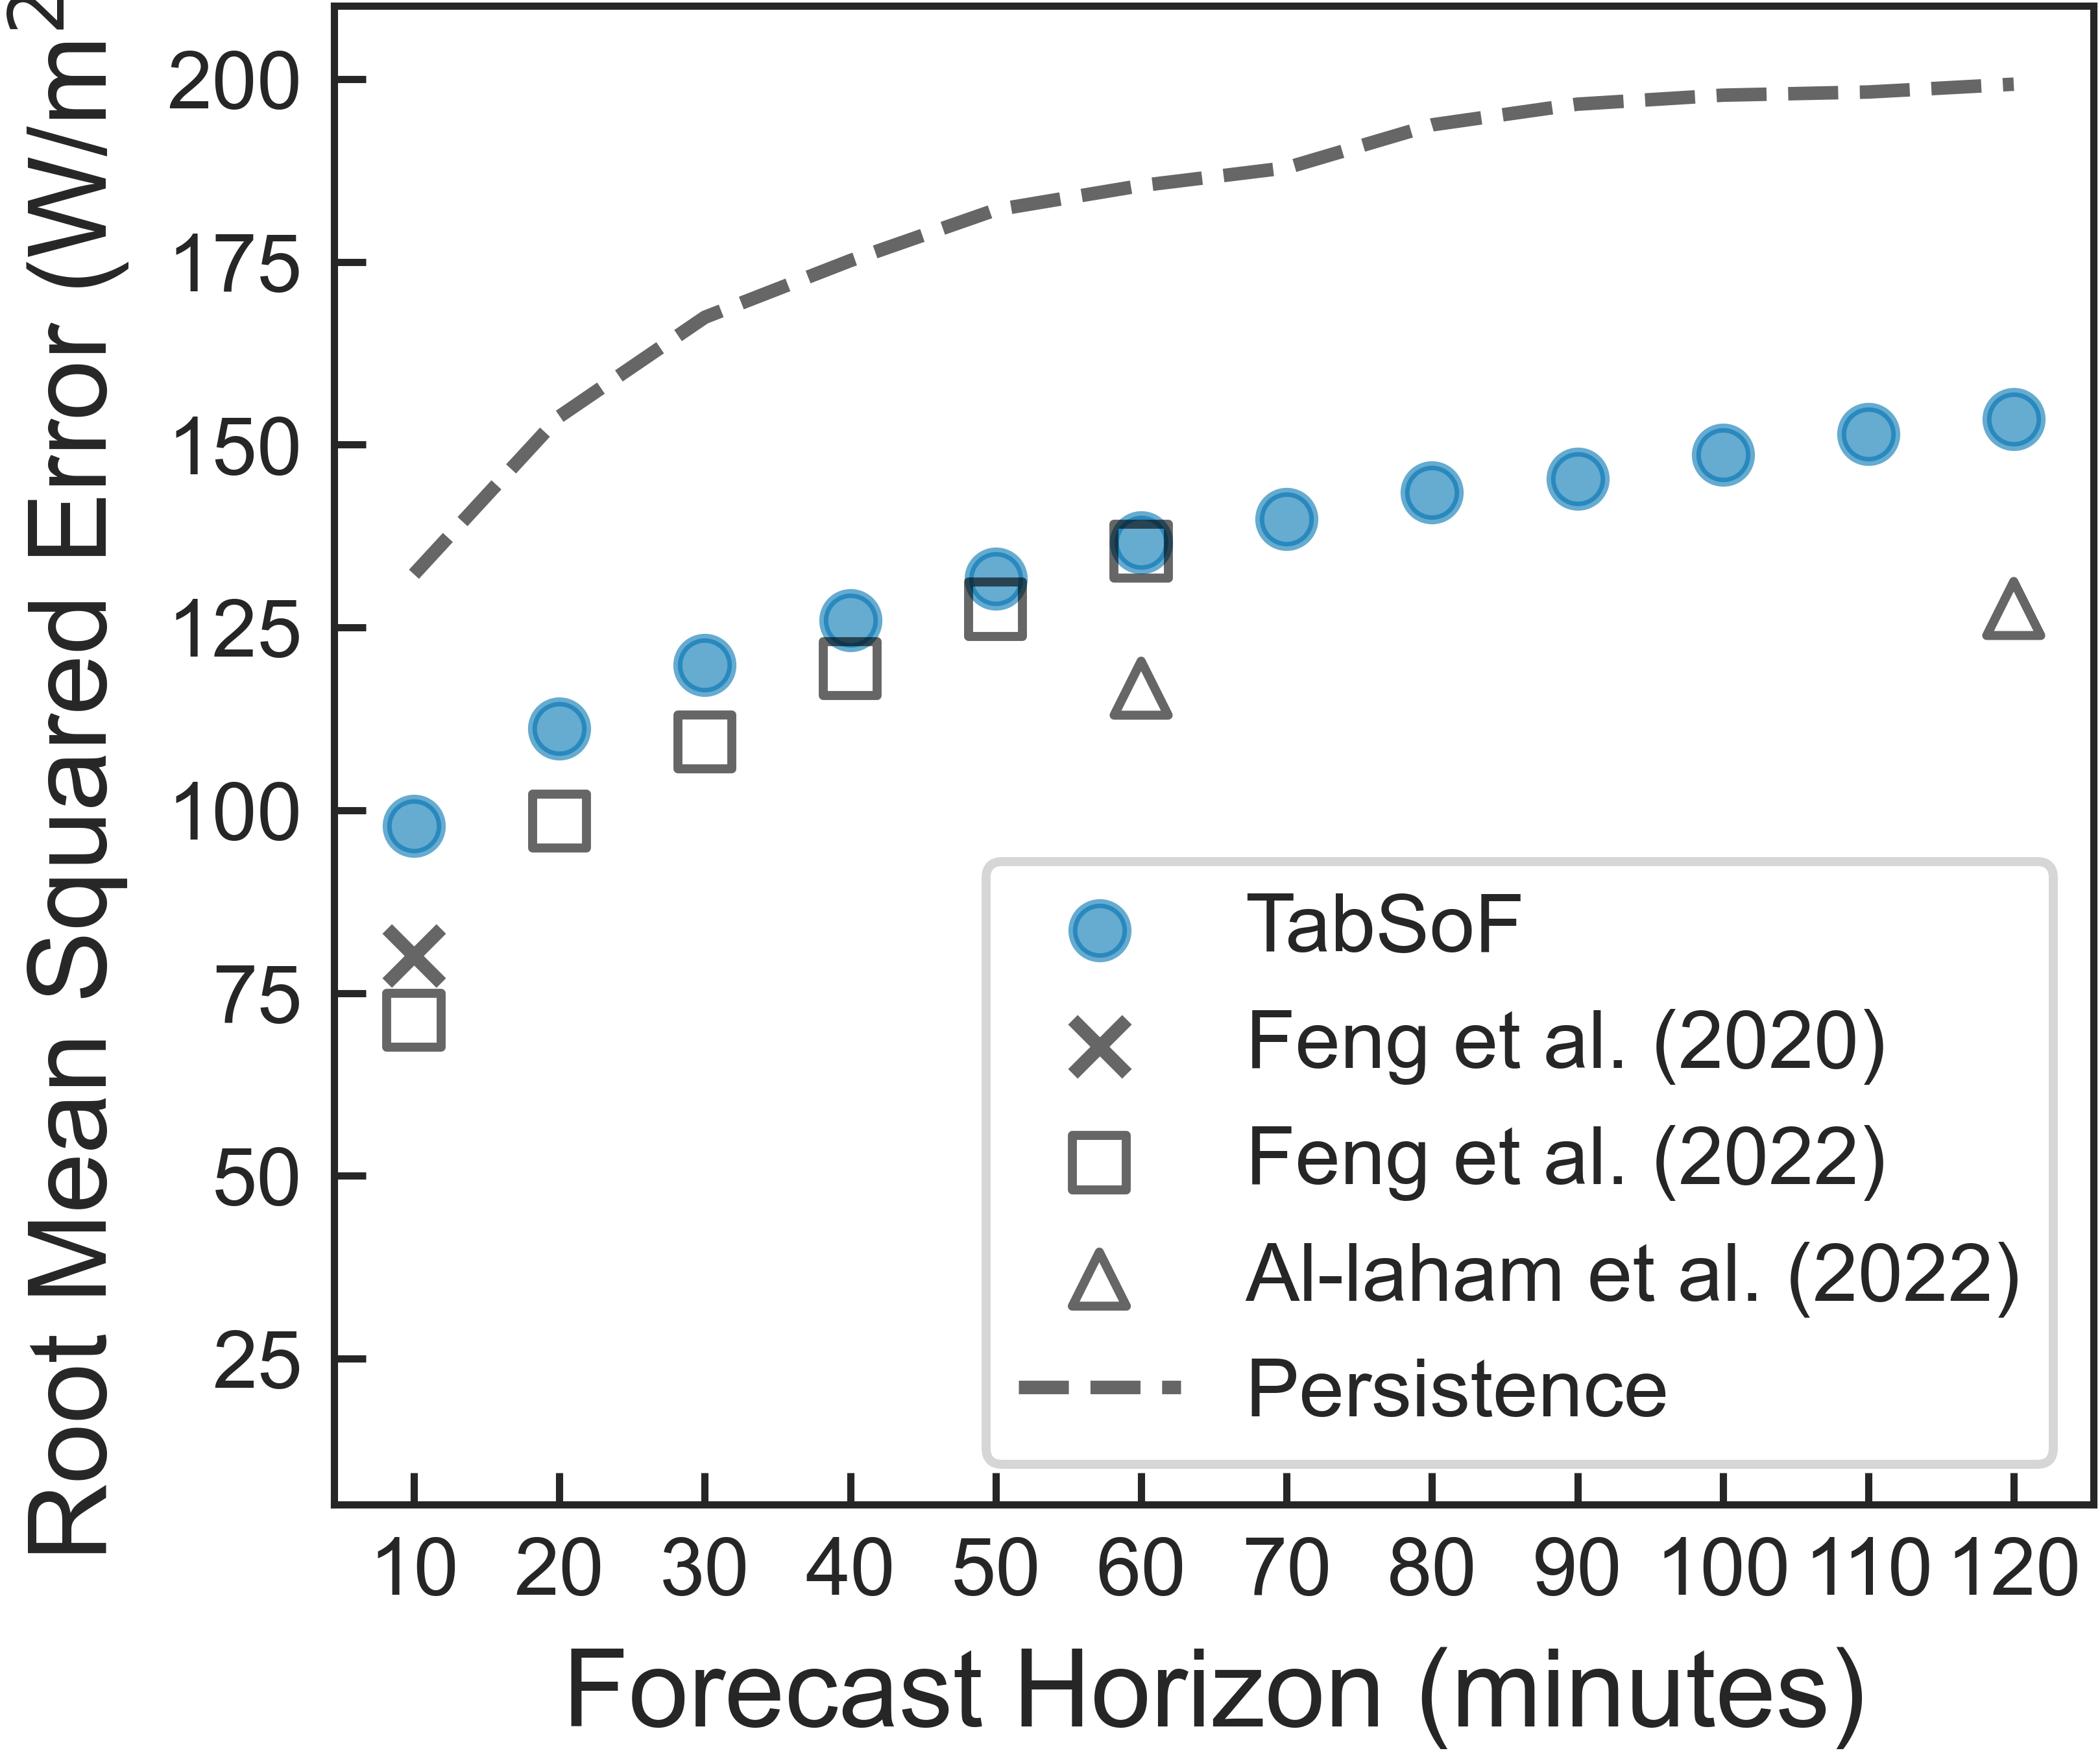

In [29]:
# RMSE v Forecast horizon
RMSE_train_cols = [f"CV 3: Train RMSE t+{i+1}0 min" for i in range(12)]
RMSE_validate_cols = [f"CV 3: Validate RMSE t+{i+1}0 min" for i in range(12)]
RMSE_validate_persistence_cols = [
    f"CV 3: Validate Persistence RMSE t+{i+1}0 min" for i in range(12)
]
RMSE_FS_train_cols = [f"CV 3: Train FS RMSE t+{i+1}0 min" for i in range(12)]
RMSE_FS_validate_cols = [f"CV 3: Validate FS RMSE t+{i+1}0 min" for i in range(12)]

x = np.arange(10, 130, 10)
y = clipped_df[RMSE_validate_cols].values
yy = clipped_df[RMSE_validate_persistence_cols].values[2]
# labels = clipped_df["selected responses"].values
labels = ["  TabSoF  "]
markers = ["o", "^", "s", "D", "P"]

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=1000)
for i in [0]:
    ax.scatter(x, y[i], label=labels[i][2:-2], marker=markers[i], alpha=0.6)

# literature results
ax.scatter(
    feng_2020_rmse.T[0],
    feng_2020_rmse.T[1],
    marker="x",
    label="Feng et al. (2020)",
    color="black",
    alpha=0.6,
)
ax.scatter(
    feng_2022_rmse.T[0],
    feng_2022_rmse.T[1],
    marker="s",
    facecolors="none",
    label="Feng et al. (2022)",
    color="black",
    alpha=0.6,
)
ax.scatter(
    allaham_asi_rmse.T[0][1:3],
    allaham_asi_rmse.T[1][1:3],
    marker="^",
    facecolors="none",
    label="Al-laham et al. (2022)",
    color="black",
    alpha=0.6,
)

ax.plot(x, yy, label="Persistence", color="black", linestyle="--", alpha=0.6)

ax.set_ylim(5, 210)
# ax.grid()
ax.set_ylabel(r"Root Mean Squared Error (W/m$^2$)", fontsize=12)
ax.set_xlabel(r"Forecast Horizon (minutes)", fontsize=12)

x_ticks = np.arange(10, 130, 10)
ax.set_xticks(x_ticks)

plt.legend(loc="lower right")

# plt.savefig(os.path.join(fig_dir, "RMSE v Forecast horizon.png"), bbox_inches="tight")
plt.savefig(os.path.join(fig_dir, "RMSE v Forecast horizon.pdf"), bbox_inches="tight")

plt.show()

## nMAE


In [30]:
nmap = (np.abs(true - predicted) / true.mean()).mean(axis=0) * 100
print(nmap[:6])
print(nmap[6:])
print(nmap.mean())

[ 9.63659959 11.89757485 13.44905224 14.68770214 15.83222041 16.79722967]
[17.45493403 18.03018112 18.62788711 19.19295323 19.58273205 19.97386804]
16.26357787343075


## nmap


In [31]:
nmap = (np.abs(true - persistence) / true.mean()).mean(axis=0) * 100
print(nmap[:6])
print(nmap[6:])
print(nmap.mean())

[21.53462761 22.77775237 24.61171766 26.16025495 27.83924212 29.0829418 ]
[30.07353315 31.60633757 32.56819764 33.41272596 34.08386222 34.89047726]
29.053472525662553
